<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo 37** | Regressão Logística II
Caderno de **exercício II**<br>




## Discente: Samuel Saturno

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# Importando as Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import t
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve

import warnings

In [2]:
# Carregando a base de dados

df = pd.read_feather('/content/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
def IV(variavel, resposta):
    # Cria uma tabela de contingência (cross-tabulation) entre a variável explicativa e a resposta
    # `margins=True` adiciona uma linha e uma coluna de totais, e `margins_name` nomeia esses totais como 'total'
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    # Extrai os nomes das colunas para os eventos (primeira coluna) e não eventos (segunda coluna)
    tulo_evento = tab.columns[0]  # Nome da coluna correspondente ao evento (geralmente classe positiva)
    tulo_nao_evento = tab.columns[1]  # Nome da coluna correspondente ao não-evento (geralmente classe negativa)

    # Calcula a porcentagem de eventos em cada categoria da variável
    tab['pct_evento'] = tab[tulo_evento] / tab.loc['total', tulo_evento]

    # Parece que esta linha é redundante, já que repete o cálculo de 'pct_evento'
    tab['ep'] = tab[tulo_evento] / tab.loc['total', tulo_evento]

    # Calcula a porcentagem de não-eventos em cada categoria da variável
    tab['pct_nao_evento'] = tab[tulo_nao_evento] / tab.loc['total', tulo_nao_evento]

    # Calcula o Weight of Evidence (WoE), que é o logaritmo da razão entre as porcentagens de eventos e não-eventos
    tab['woe'] = np.log(tab.pct_evento / tab.pct_nao_evento)

    # Calcula o Information Value (IV) parcial para cada categoria
    # IV parcial é o produto da diferença entre as porcentagens de eventos e não-eventos com o WoE
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento) * tab.woe

    # Retorna a soma do IV parcial, que é o Information Value total da variável
    return tab['iv_parcial'].sum()


In [4]:
def biv_discreta(var, df):
    # Adiciona uma nova coluna 'bom', que é complementar a coluna 'mau' (indicador binário de "bom" ou "mau")
    df['bom'] = 1 - df.mau

    # Agrupa o DataFrame pela variável categórica fornecida em `var`
    g = df.groupby(var)

    # Cria um novo DataFrame com informações sumarizadas:
    # - `qt_bom`: soma da coluna 'bom' para cada categoria
    # - `qt_mau`: soma da coluna 'mau' para cada categoria
    # - `mau`: proporção média de "mau" em cada categoria
    # - `var`: nome das categorias (índice do agrupamento)
    # - `cont`: contagem de ocorrências em cada categoria
    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(),
        var: g['mau'].mean().index,
        'cont': g[var].count()
    })

    # Calcula o erro-padrão (ep) da proporção de "mau" para cada categoria
    biv['ep'] = (biv.mau * (1 - biv.mau) / biv.cont) ** 0.5

    # Calcula os limites de confiança superior e inferior para a proporção de "mau" (nível de confiança 95%)
    biv['mau_sup'] = biv.mau + t.ppf([0.975], biv.cont - 1) * biv.ep  # Limite superior
    biv['mau_inf'] = biv.mau + t.ppf([0.025], biv.cont - 1) * biv.ep  # Limite inferior

    # Calcula o logit (log odds) para a proporção de "mau" e seus limites de confiança
    biv['logit'] = np.log(biv.mau / (1 - biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup / (1 - biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf / (1 - biv.mau_inf))

    # Calcula a taxa geral de "mau" no DataFrame
    tx_mau_geral = df.mau.mean()

    # Calcula o logit geral (log odds) para a taxa geral de "mau"
    woe_geral = np.log(tx_mau_geral / (1 - tx_mau_geral))

    # Calcula o Weight of Evidence (WoE) para cada categoria
    # Diferença entre o logit de cada categoria e o logit geral
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral  # Limite superior para o WoE
    biv['woe_inf'] = biv.logit_inf - woe_geral  # Limite inferior para o WoE

    # Plota gráficos para visualização do WoE
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    # Primeiro gráfico: WoE e seus limites superior/inferior
    ax[0].plot(biv[var], biv.woe, ':bo', label='WoE')  # WoE como pontos azuis
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='Limite superior')  # Limite superior como pontos vermelhos
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='Limite inferior')  # Limite inferior como pontos vermelhos

    # Ajusta o eixo x para incluir todas as categorias
    num_cat = biv.shape[0]  # Número de categorias
    ax[0].set_xlim([-0.3, num_cat - 0.7])

    # Adiciona rótulo ao eixo y e uma legenda
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(0.83, 1.17), ncol=3)  # Posiciona a legenda

    # Define as categorias no eixo x e rotaciona os rótulos
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=8)

    # Segundo gráfico: barras representando a contagem de ocorrências por categoria
    ax[1] = biv.cont.plot.bar()

    # Retorna o DataFrame com os cálculos
    return biv


In [5]:
def biv_continua(var, ncat, df):
    # Cria uma nova coluna 'bom', que é complementar à coluna 'mau' (indicador binário de "bom" ou "mau")
    df['bom'] = 1 - df.mau

    # Divide a variável contínua `var` em `ncat` categorias com quantidades iguais de dados em cada bin
    # `retbins=True` retorna os limites dos intervalos (bins)
    # `precision=0` arredonda os limites dos intervalos para o número inteiro mais próximo
    # `duplicates='drop'` descarta intervalos duplicados caso não seja possível dividir uniformemente
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')

    # Agrupa os dados por essas categorias (bins) criadas
    g = df.groupby(cat_srs)

    # Cria um DataFrame com métricas sumarizadas:
    # - `qt_bom`: soma de "bons" (1 - mau) em cada bin
    # - `qt_mau`: soma de "maus" em cada bin
    # - `mau`: proporção de "maus" em cada bin
    # - `var`: valor médio de `var` em cada bin
    # - `cont`: número de ocorrências (tamanho) de cada bin
    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(),
        var: g[var].mean(),
        'cont': g[var].count()
    })

    # Calcula o erro-padrão (ep) da proporção de "maus" em cada bin
    biv['ep'] = (biv.mau * (1 - biv.mau) / biv.cont) ** 0.5

    # Calcula os limites de confiança superior e inferior para a proporção de "maus" (nível de confiança 95%)
    biv['mau_sup'] = biv.mau + t.ppf([0.975], biv.cont - 1) * biv.ep  # Limite superior
    biv['mau_inf'] = biv.mau + t.ppf([0.025], biv.cont - 1) * biv.ep  # Limite inferior

    # Calcula o logit (log odds) para a proporção de "maus" e seus limites de confiança
    biv['logit'] = np.log(biv.mau / (1 - biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup / (1 - biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf / (1 - biv.mau_inf))

    # Calcula a taxa geral de "maus" no DataFrame
    tx_mau_geral = df.mau.mean()

    # Calcula o logit geral (log odds) para a taxa geral de "maus"
    woe_geral = np.log(tx_mau_geral / (1 - tx_mau_geral))

    # Calcula o Weight of Evidence (WoE) para cada bin:
    # Diferença entre o logit do bin e o logit geral
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral  # Limite superior para o WoE
    biv['woe_inf'] = biv.logit_inf - woe_geral  # Limite inferior para o WoE

    # Plota gráficos para visualização do WoE
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    # Primeiro gráfico: WoE e seus limites superior/inferior
    ax[0].plot(biv[var], biv.woe, ':bo', label='WoE')  # WoE como pontos azuis
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='Limite superior')  # Limite superior como pontos vermelhos
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='Limite inferior')  # Limite inferior como pontos vermelhos

    # Define o rótulo do eixo y e adiciona uma legenda
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(0.83, 1.17), ncol=3)  # Posiciona a legenda

    # Segundo gráfico: barras representando a contagem de ocorrências por bin
    ax[1] = biv.cont.plot.bar()

    # Retorna None (os gráficos são exibidos como saída principal)
    return None


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [7]:
' + '.join(list(df.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau'

In [8]:
df.data_ref.value_counts()

,count
data_ref,
2015-01-01,50000
2015-02-01,50000
2015-03-01,50000
2015-04-01,50000
2015-05-01,50000
2015-06-01,50000
2015-07-01,50000
2015-08-01,50000
2015-09-01,50000


In [9]:
# Define a coluna 'data_ref' como índice do DataFrame
# Isso é útil quando a coluna 'data_ref' representa uma série temporal (datas),
# permitindo acesso facilitado por intervalos de tempo.
df.set_index('data_ref', inplace=True)

# Cria o DataFrame de treino (df_train) com os dados do intervalo entre '2015-01-01' e '2015-12-01'
# Este comando utiliza indexação de fatias (slices) em um DataFrame com índices baseados em datas.
df_train = df['2015-01-01':'2015-12-01']

# Cria o DataFrame de teste (df_test) com os dados a partir de '2016-01-01'
# Como o intervalo não tem um ponto de término especificado, ele inclui todos os dados após essa data.
df_test = df['2016-01-01':]


In [10]:
# Redefine o índice do DataFrame de treino (df_train) como uma coluna regular
# O parâmetro `inplace=True` faz com que a modificação seja aplicada diretamente ao DataFrame original
df_train.reset_index(inplace=True)

# Redefine o índice do DataFrame de teste (df_test) como uma coluna regular
# O índice anteriormente definido (geralmente baseado em datas) volta a ser uma coluna
df_test.reset_index(inplace=True)


In [11]:
# Cria uma nova coluna 'Mes' no DataFrame de treino (df_train)
# A coluna 'Mes' é derivada da coluna 'data_ref', extraindo o número do mês
# `.dt` é um acessor usado para manipular dados de tipo datetime em pandas
df_train['Mes'] = df_train['data_ref'].dt.month

# Suprime os avisos emitidos pelo pandas (ou outras bibliotecas)
# `warnings.filterwarnings('ignore')` ignora mensagens de aviso durante a execução do código
# Isso pode ser útil para evitar poluição visual no terminal, mas deve ser usado com cuidado
warnings.filterwarnings('ignore')


<ipython-input-11-562ff5f2320b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Mes'] = df_train['data_ref'].dt.month


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

Text(0.5, 1.0, 'Número de linhas para cada mês da base de treino')

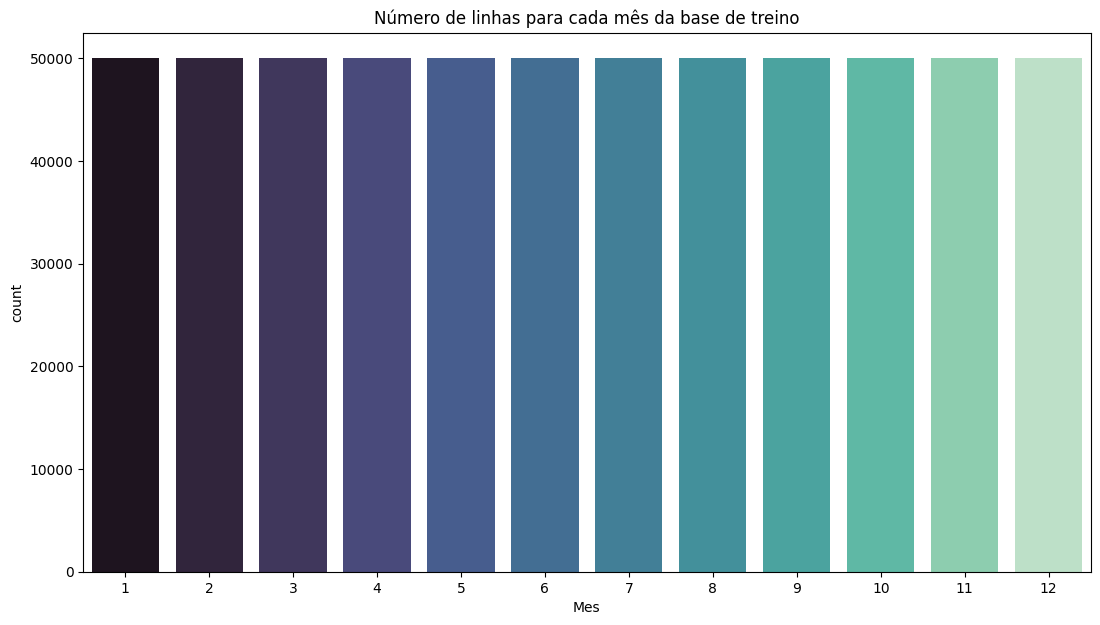

In [12]:
# Cria uma figura e um conjunto de eixos (ax) para o gráfico
# Define o tamanho da figura para 13 de largura e 7 de altura
fig, ax = plt.subplots(figsize=(13, 7))

# Gera um gráfico de contagem (countplot) usando Seaborn
# - `data=df_train`: especifica que os dados usados são do DataFrame de treino (df_train)
# - `x='Mes'`: os valores da coluna 'Mes' serão usados como rótulos no eixo X
# - `palette='mako'`: define a paleta de cores do gráfico como 'mako' (uma paleta predefinida do Seaborn)
# - `ax=ax`: plota o gráfico nos eixos definidos anteriormente
sns.countplot(data=df_train, x='Mes', palette='mako', ax=ax)

# Define o título do gráfico
ax.set_title('Número de linhas para cada mês da base de treino')


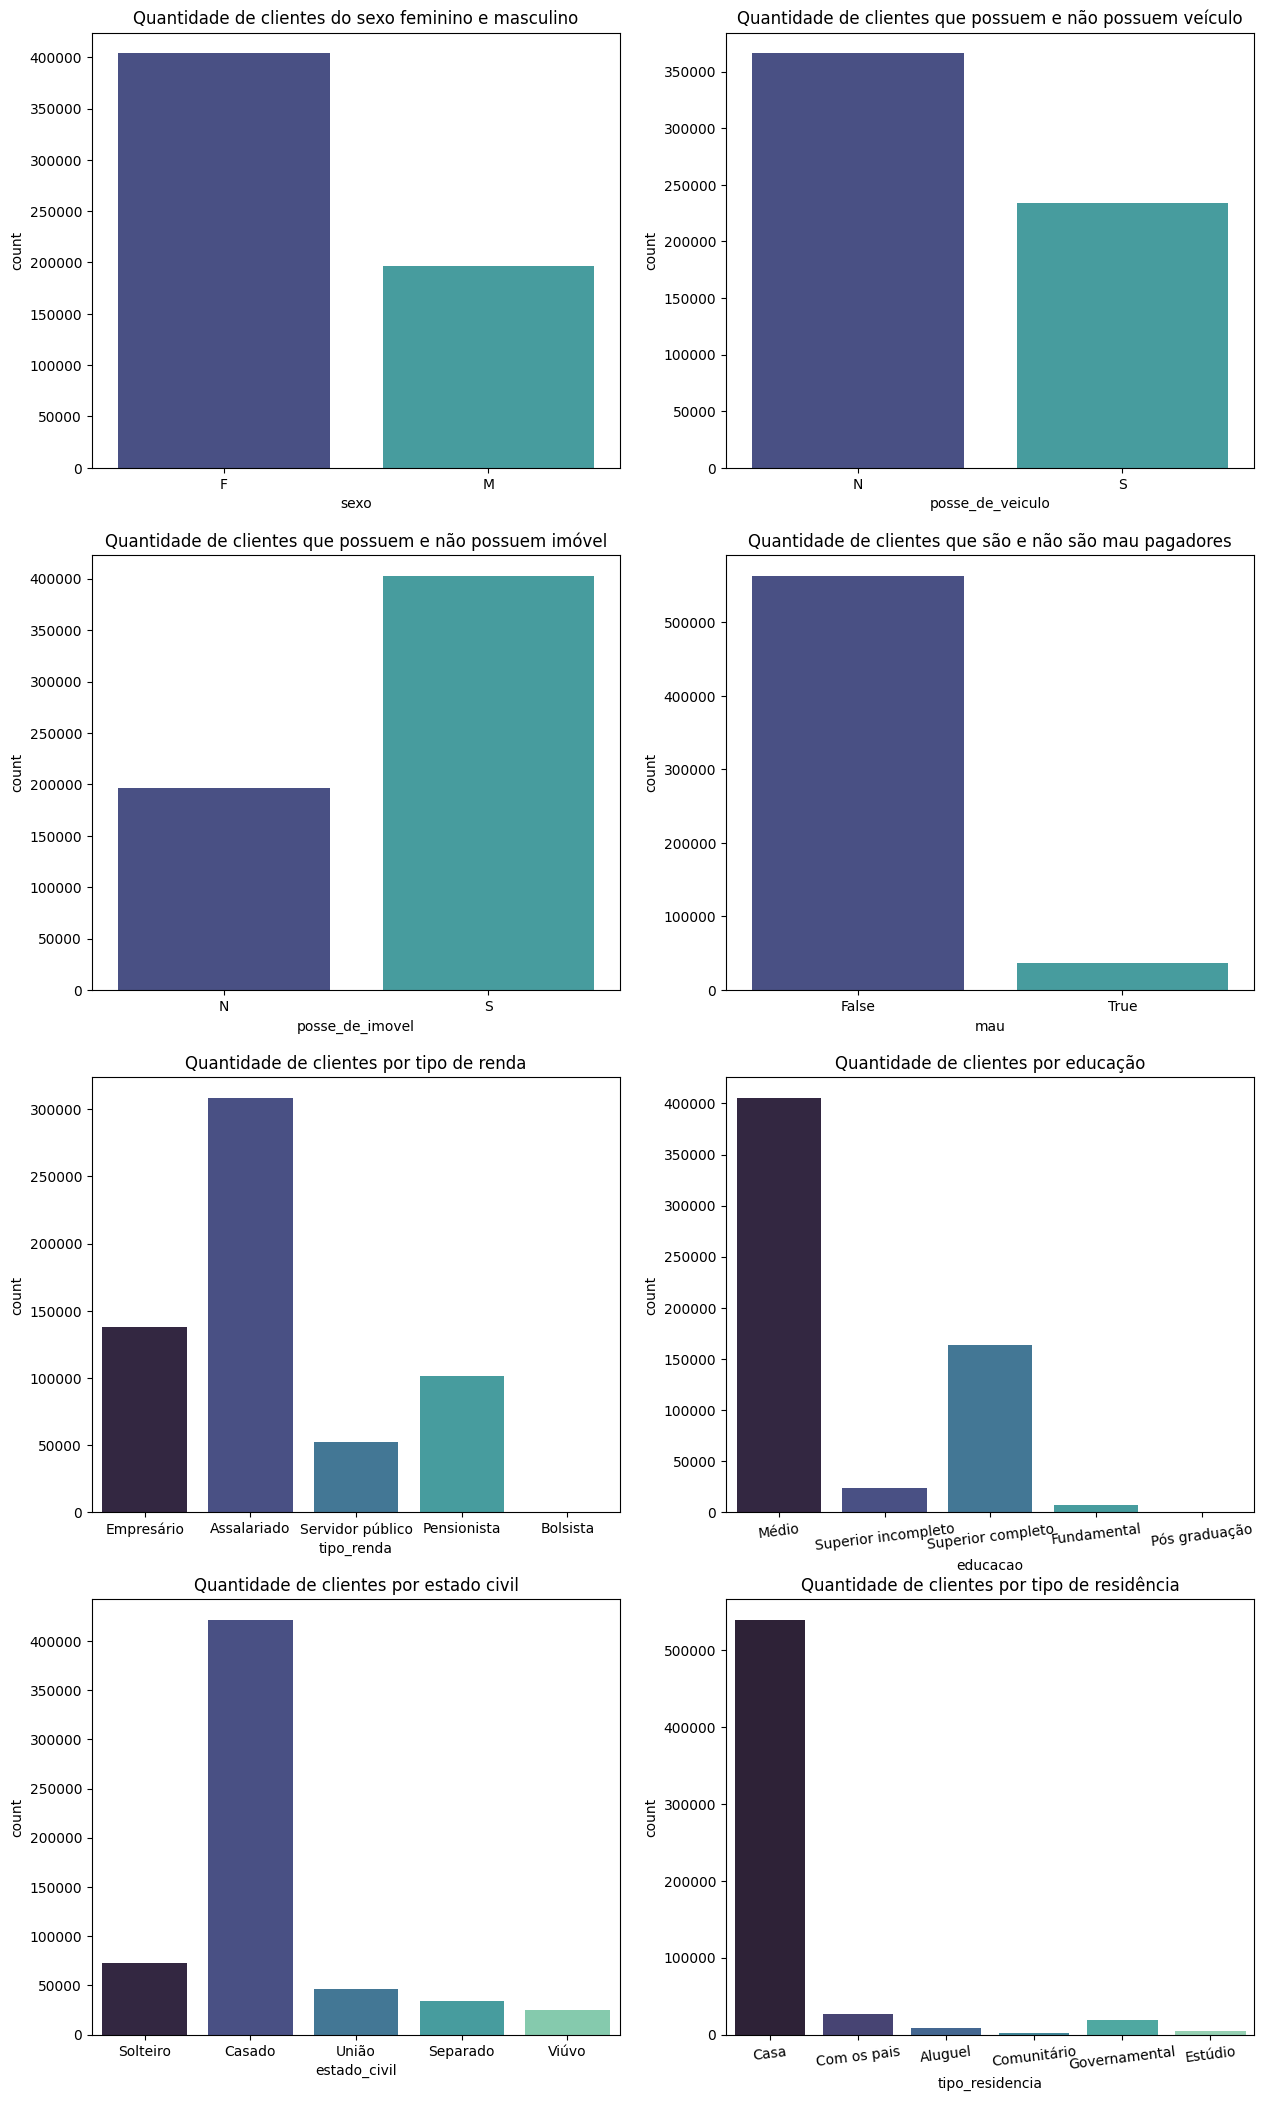

In [13]:
# Cria uma figura com múltiplos gráficos organizados em uma grade de 4 linhas e 2 colunas
# Define o tamanho da figura como 15 de largura e 26 de altura
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 26))

# 1º Gráfico: Distribuição de clientes por sexo
# - `x='sexo'`: coluna que será usada no eixo X
# - `palette='mako'`: paleta de cores para as barras
# - `ax=ax[0,0]`: define o gráfico na posição (linha 0, coluna 0) da grade
sns.countplot(data=df_train, x='sexo', palette='mako', ax=ax[0,0])
ax[0,0].set_title('Quantidade de clientes do sexo feminino e masculino')  # Adiciona o título do gráfico

# 2º Gráfico: Distribuição de clientes por posse de veículo
sns.countplot(data=df_train, x='posse_de_veiculo', palette='mako', ax=ax[0,1])
ax[0,1].set_title('Quantidade de clientes que possuem e não possuem veículo')

# 3º Gráfico: Distribuição de clientes por posse de imóvel
sns.countplot(data=df_train, x='posse_de_imovel', palette='mako', ax=ax[1,0])
ax[1,0].set_title('Quantidade de clientes que possuem e não possuem imóvel')

# 4º Gráfico: Distribuição de clientes por status de mau pagador
sns.countplot(data=df_train, x='mau', palette='mako', ax=ax[1,1])
ax[1,1].set_title('Quantidade de clientes que são e não são mau pagadores')

# 5º Gráfico: Distribuição de clientes por tipo de renda
sns.countplot(data=df_train, x='tipo_renda', palette='mako', ax=ax[2,0])
ax[2,0].set_title('Quantidade de clientes por tipo de renda')

# 6º Gráfico: Distribuição de clientes por nível de educação
sns.countplot(data=df_train, x='educacao', palette='mako', ax=ax[2,1])
ax[2,1].set_title('Quantidade de clientes por educação')
# Rotaciona os rótulos do eixo X para evitar sobreposição
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

# 7º Gráfico: Distribuição de clientes por estado civil
sns.countplot(data=df_train, x='estado_civil', palette='mako', ax=ax[3,0])
ax[3,0].set_title('Quantidade de clientes por estado civil')

# 8º Gráfico: Distribuição de clientes por tipo de residência
sns.countplot(data=df_train, x='tipo_residencia', palette='mako', ax=ax[3,1])
ax[3,1].set_title('Quantidade de clientes por tipo de residência')
# Rotaciona os rótulos do eixo X para evitar sobreposição
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7)


Text(0.5, 1.0, 'Quantidade de clientes por renda')

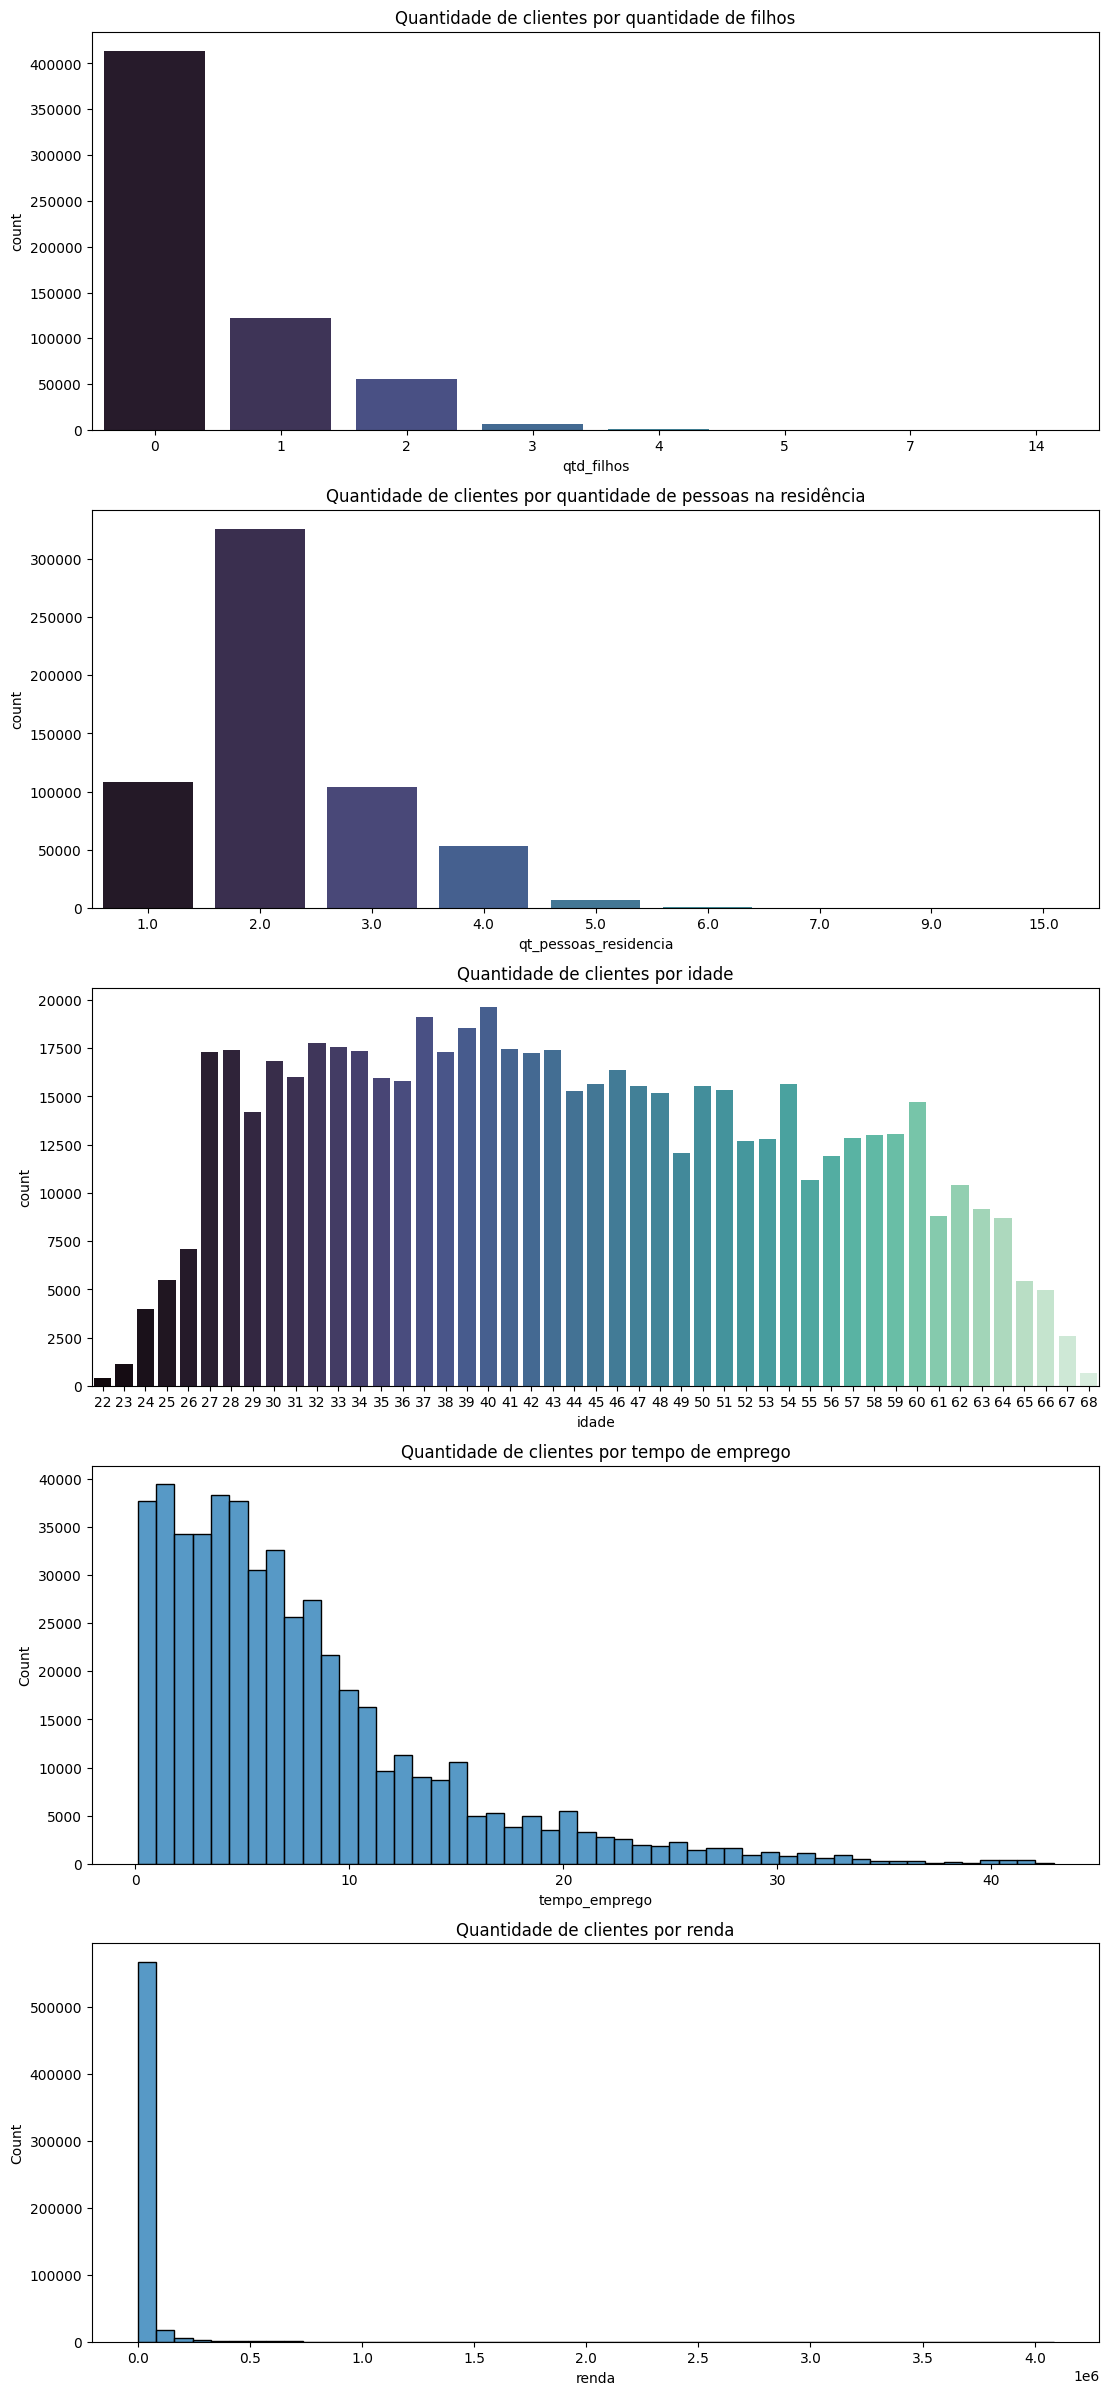

In [14]:
# Cria uma figura com 5 gráficos organizados verticalmente (em uma única coluna)
# Define o tamanho da figura como 13 de largura e 30 de altura
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(13, 30))

# 1º Gráfico: Distribuição de clientes por quantidade de filhos
# - `x='qtd_filhos'`: usa a coluna 'qtd_filhos' como eixo X
# - `palette='mako'`: aplica a paleta de cores 'mako' para as barras
# - `ax=ax[0]`: posiciona o gráfico no primeiro eixo (linha 0)
sns.countplot(data=df_train, x='qtd_filhos', palette='mako', ax=ax[0])
ax[0].set_title('Quantidade de clientes por quantidade de filhos')  # Define o título do gráfico

# 2º Gráfico: Distribuição de clientes por quantidade de pessoas na residência
sns.countplot(data=df_train, x='qt_pessoas_residencia', palette='mako', ax=ax[1])
ax[1].set_title('Quantidade de clientes por quantidade de pessoas na residência')

# 3º Gráfico: Distribuição de clientes por idade
sns.countplot(data=df_train, x='idade', palette='mako', ax=ax[2])
ax[2].set_title('Quantidade de clientes por idade')

# 4º Gráfico: Distribuição de clientes por tempo de emprego
# - Usa um histograma (histplot) para visualizar a distribuição da variável contínua 'tempo_emprego'
# - `bins=50`: divide os dados em 50 intervalos (bins) para o histograma
# - `palette='dark'`: aplica uma paleta de cores mais escura
sns.histplot(data=df_train, x='tempo_emprego', palette='dark', bins=50, ax=ax[3])
ax[3].set_title('Quantidade de clientes por tempo de emprego')

# 5º Gráfico: Distribuição de clientes por renda
# - Outro histograma, desta vez para a variável 'renda'
sns.histplot(data=df_train, x='renda', palette='dark', bins=50, ax=ax[4])
ax[4].set_title('Quantidade de clientes por renda')


Text(0.5, 1.0, 'Quantidade de clientes por renda menor que 50000 reais')

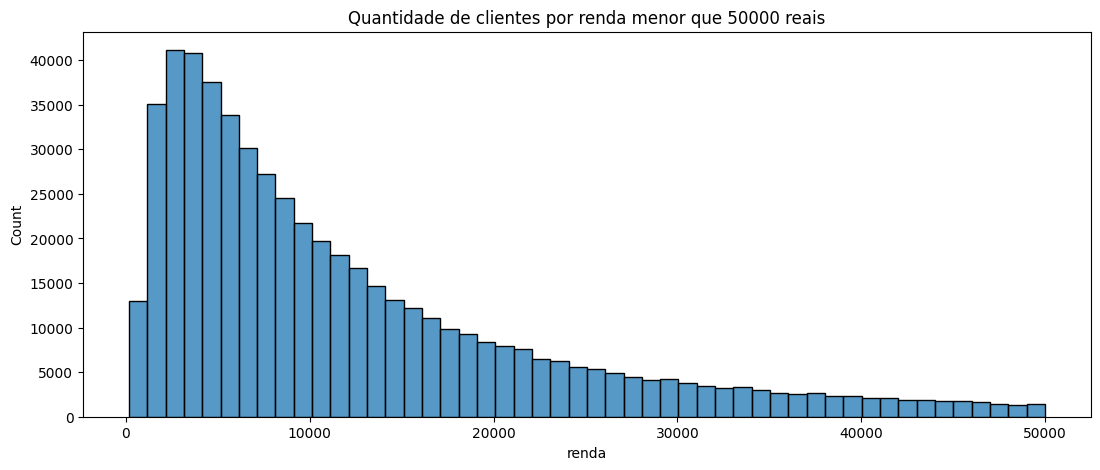

In [15]:
# Cria uma figura e um eixo (ax) para o gráfico
# Define o tamanho da figura como 13 de largura e 5 de altura
fig, ax = plt.subplots(figsize=(13, 5))

# Plota um histograma (histplot) para a variável 'renda'
# - `data=df_train[df_train.renda<50000]`: filtra os dados para incluir apenas clientes com renda menor que 50.000
# - `x='renda'`: a coluna 'renda' é usada no eixo X
# - `palette='dark'`: aplica uma paleta de cores escura para o histograma
# - `bins=50`: divide os dados em 50 intervalos (bins) para o histograma
# - `ax=ax`: plota o gráfico no eixo definido anteriormente
sns.histplot(data=df_train[df_train.renda < 50000], x='renda', palette='dark', bins=50, ax=ax)

# Define o título do gráfico, explicando o que está sendo visualizado
ax.set_title('Quantidade de clientes por renda menor que 50000 reais')


Text(0.5, 1.0, 'Quantidade de clientes por renda maior que 500000 reais')

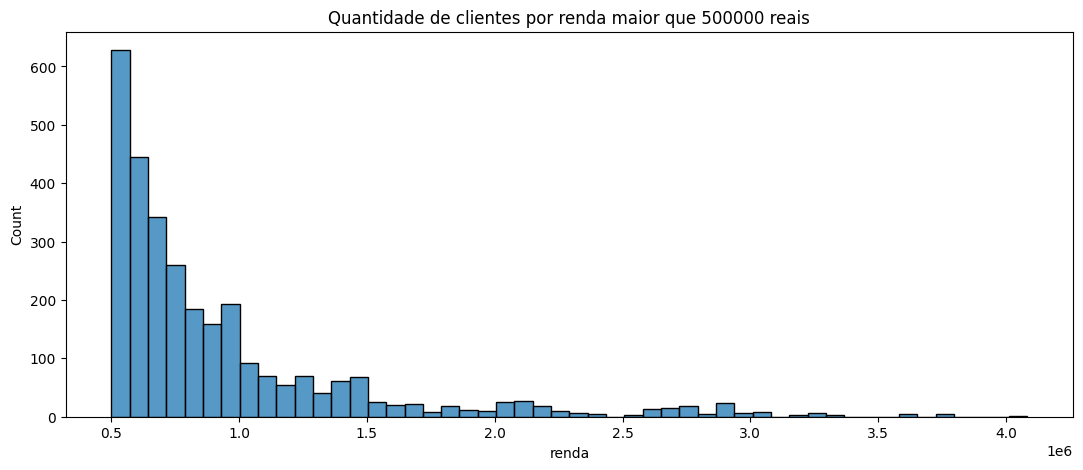

In [16]:
# Cria uma figura e um eixo (ax) para o gráfico
# Define o tamanho da figura como 13 de largura e 5 de altura
fig, ax = plt.subplots(figsize=(13, 5))

# Plota um histograma (histplot) para a variável 'renda'
# - `data=df_train[df_train.renda>500000]`: filtra os dados para incluir apenas clientes com renda maior que 500.000
# - `x='renda'`: a coluna 'renda' será usada no eixo X
# - `palette='dark'`: aplica uma paleta de cores mais escura para o histograma
# - `bins=50`: divide os valores de renda em 50 intervalos (bins) para o histograma
# - `ax=ax`: especifica o eixo onde o gráfico será plotado
sns.histplot(data=df_train[df_train.renda > 500000], x='renda', palette='dark', bins=50, ax=ax)

# Define o título do gráfico, explicando o que está sendo visualizado
ax.set_title('Quantidade de clientes por renda maior que 500000 reais')


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Text(0, 0.5, 'Proporção de inadimplentes')

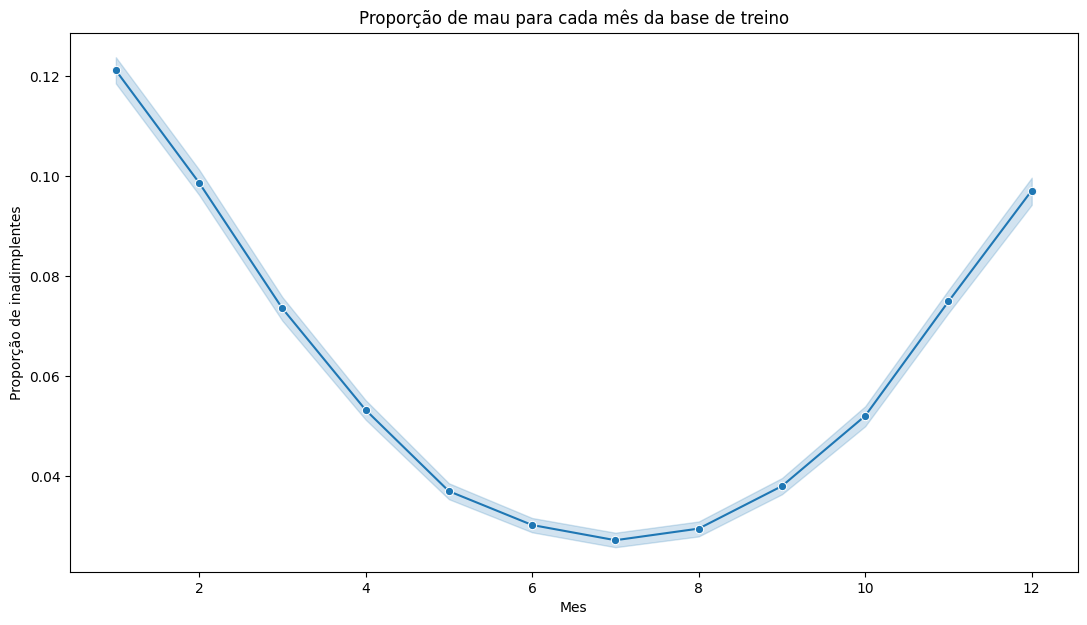

In [17]:
# Cria uma figura e um eixo (ax) para o gráfico
# Define o tamanho da figura como 13 de largura e 7 de altura
fig, ax = plt.subplots(figsize=(13, 7))

# Plota um gráfico de linha (lineplot) para analisar a proporção de "mau" por mês
# - `data=df_train`: usa o DataFrame de treino como fonte dos dados
# - `x='Mes'`: usa a coluna 'Mes' (mês) como eixo X
# - `y='mau'`: usa a coluna 'mau' como eixo Y, que representa a proporção de inadimplentes
# - `palette='mako'`: aplica a paleta de cores 'mako' para o gráfico
# - `ax=ax`: plota o gráfico no eixo especificado
# - `marker='o'`: adiciona marcadores ('o') nos pontos da linha para destacar os dados
sns.lineplot(data=df_train, x='Mes', y='mau', palette='mako', ax=ax, marker='o')

# Define o título do gráfico, explicando o que está sendo analisado
ax.set_title('Proporção de mau para cada mês da base de treino')

# Define o rótulo do eixo Y para indicar que ele representa a proporção de inadimplentes
ax.set_ylabel("Proporção de inadimplentes")


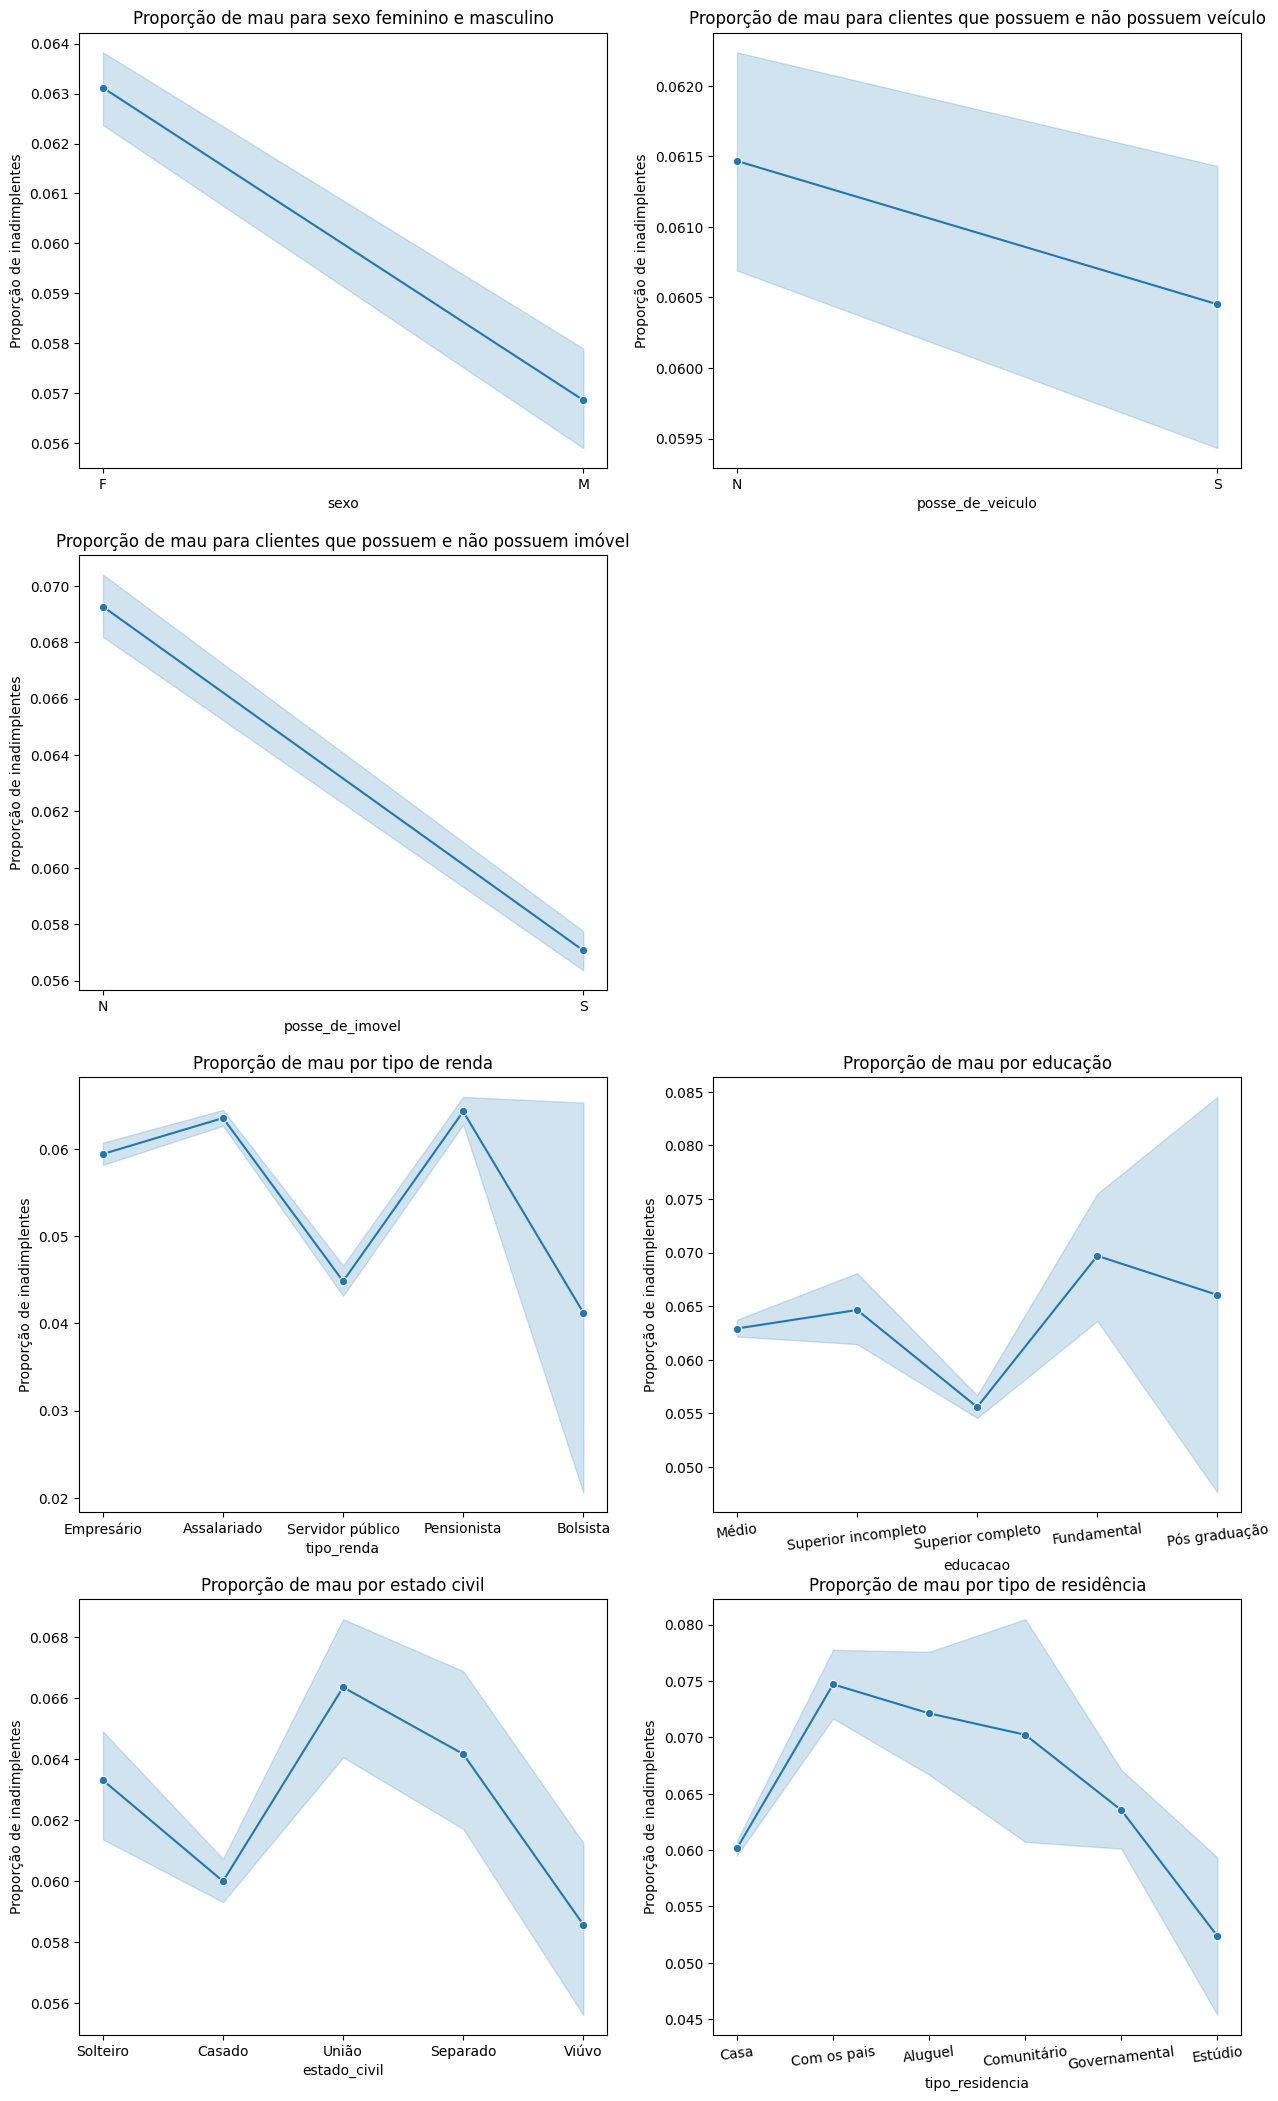

In [18]:
# Cria uma figura com 8 gráficos dispostos em uma grade de 4 linhas e 2 colunas
# Define o tamanho da figura como 15 de largura e 26 de altura
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 26))

# 1º Gráfico: Proporção de inadimplentes por sexo
# - `x='sexo'`: eixo X representa as categorias de sexo (feminino e masculino)
# - `y='mau'`: eixo Y representa a proporção de inadimplentes
# - `palette='mako'`: aplica uma paleta de cores moderna
# - `marker='o'`: adiciona marcadores nos pontos para melhor visualização
sns.lineplot(data=df_train, x='sexo', y='mau', palette='mako', ax=ax[0,0], marker='o')
ax[0,0].set_title('Proporção de mau para sexo feminino e masculino')  # Define o título do gráfico
ax[0,0].set_ylabel("Proporção de inadimplentes")  # Define o rótulo do eixo Y

# 2º Gráfico: Proporção de inadimplentes por posse de veículo
sns.lineplot(data=df_train, x='posse_de_veiculo', y='mau', palette='mako', ax=ax[0,1], marker='o')
ax[0,1].set_title('Proporção de mau para clientes que possuem e não possuem veículo')
ax[0,1].set_ylabel("Proporção de inadimplentes")

# 3º Gráfico: Proporção de inadimplentes por posse de imóvel
sns.lineplot(data=df_train, x='posse_de_imovel', y='mau', palette='mako', ax=ax[1,0], marker='o')
ax[1,0].set_title('Proporção de mau para clientes que possuem e não possuem imóvel')
ax[1,0].set_ylabel("Proporção de inadimplentes")

# Posição (linha 1, coluna 1) da grade foi desativada (sem gráfico)
ax[1,1].axis('off')  # Desativa o gráfico nesta posição

# 4º Gráfico: Proporção de inadimplentes por tipo de renda
sns.lineplot(data=df_train, x='tipo_renda', y='mau', palette='mako', ax=ax[2,0], marker='o')
ax[2,0].set_title('Proporção de mau por tipo de renda')
ax[2,0].set_ylabel("Proporção de inadimplentes")

# 5º Gráfico: Proporção de inadimplentes por nível de educação
sns.lineplot(data=df_train, x='educacao', y='mau', palette='mako', ax=ax[2,1], marker='o')
ax[2,1].set_title('Proporção de mau por educação')
ax[2,1].set_ylabel("Proporção de inadimplentes")
# Rotaciona os rótulos do eixo X para evitar sobreposição
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

# 6º Gráfico: Proporção de inadimplentes por estado civil
sns.lineplot(data=df_train, x='estado_civil', y='mau', palette='mako', ax=ax[3,0], marker='o')
ax[3,0].set_title('Proporção de mau por estado civil')
ax[3,0].set_ylabel("Proporção de inadimplentes")

# 7º Gráfico: Proporção de inadimplentes por tipo de residência
sns.lineplot(data=df_train, x='tipo_residencia', y='mau', palette='mako', ax=ax[3,1], marker='o')
ax[3,1].set_title('Proporção de mau por tipo de residência')
ax[3,1].set_ylabel("Proporção de inadimplentes")
# Rotaciona os rótulos do eixo X para evitar sobreposição
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7)


Text(0, 0.5, 'Proporção de inadimplentes')

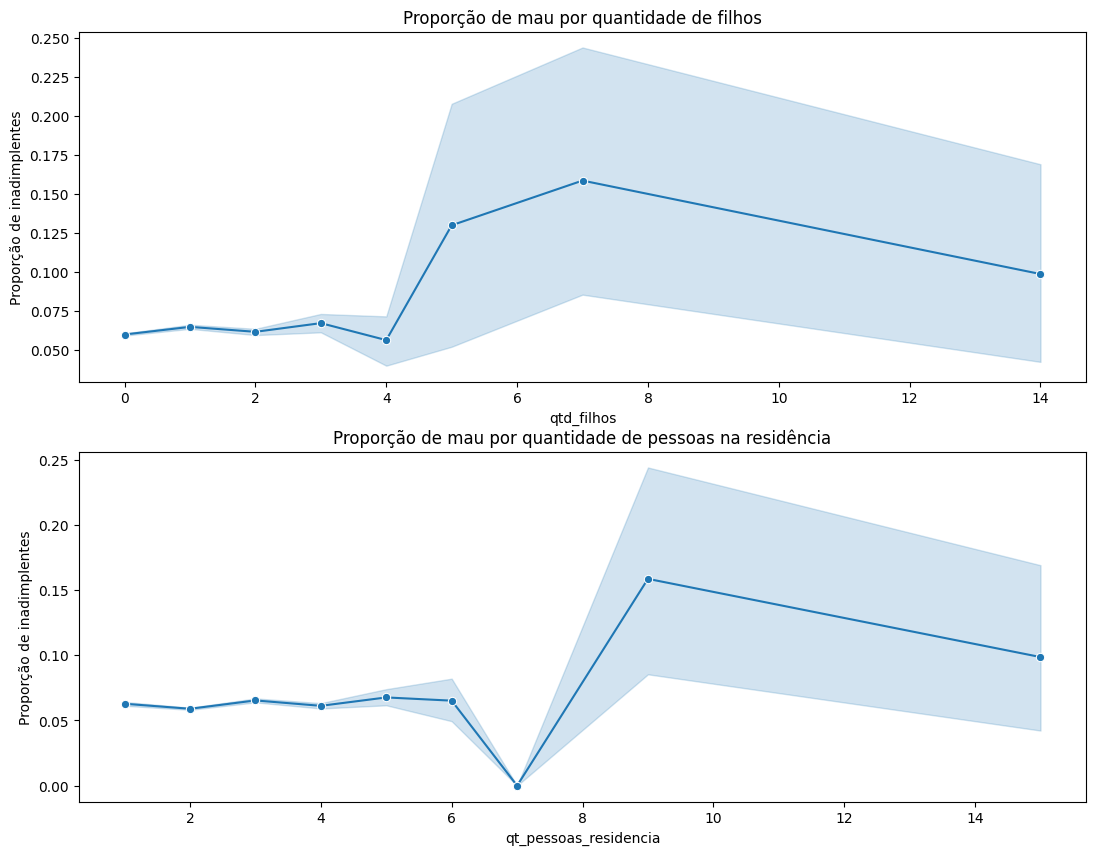

In [19]:
# Cria uma figura com 2 gráficos dispostos em 2 linhas e 1 coluna
# Define o tamanho da figura como 13 de largura e 10 de altura
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 10))

# 1º Gráfico: Proporção de inadimplentes por quantidade de filhos
# - `x='qtd_filhos'`: eixo X representa a quantidade de filhos dos clientes
# - `y='mau'`: eixo Y representa a proporção de inadimplentes
# - `palette='mako'`: aplica a paleta de cores 'mako'
# - `ax=ax[0]`: posiciona o gráfico na primeira linha da grade
# - `marker='o'`: adiciona marcadores nos pontos para destacar os valores
sns.lineplot(data=df_train, x='qtd_filhos', y='mau', palette='mako', ax=ax[0], marker='o')
ax[0].set_title('Proporção de mau por quantidade de filhos')  # Define o título do gráfico
ax[0].set_ylabel("Proporção de inadimplentes")  # Define o rótulo do eixo Y

# 2º Gráfico: Proporção de inadimplentes por quantidade de pessoas na residência
# - `x='qt_pessoas_residencia'`: eixo X representa a quantidade de pessoas na residência
# - `y='mau'`: eixo Y representa a proporção de inadimplentes
# - `palette='mako'`: aplica a mesma paleta de cores
# - `ax=ax[1]`: posiciona o gráfico na segunda linha da grade
sns.lineplot(data=df_train, x='qt_pessoas_residencia', y='mau', palette='mako', ax=ax[1], marker='o')
ax[1].set_title('Proporção de mau por quantidade de pessoas na residência')  # Define o título do gráfico
ax[1].set_ylabel("Proporção de inadimplentes")  # Define o rótulo do eixo Y


Text(0.5, 1.0, 'Proporção de mau para intervalos de idade')

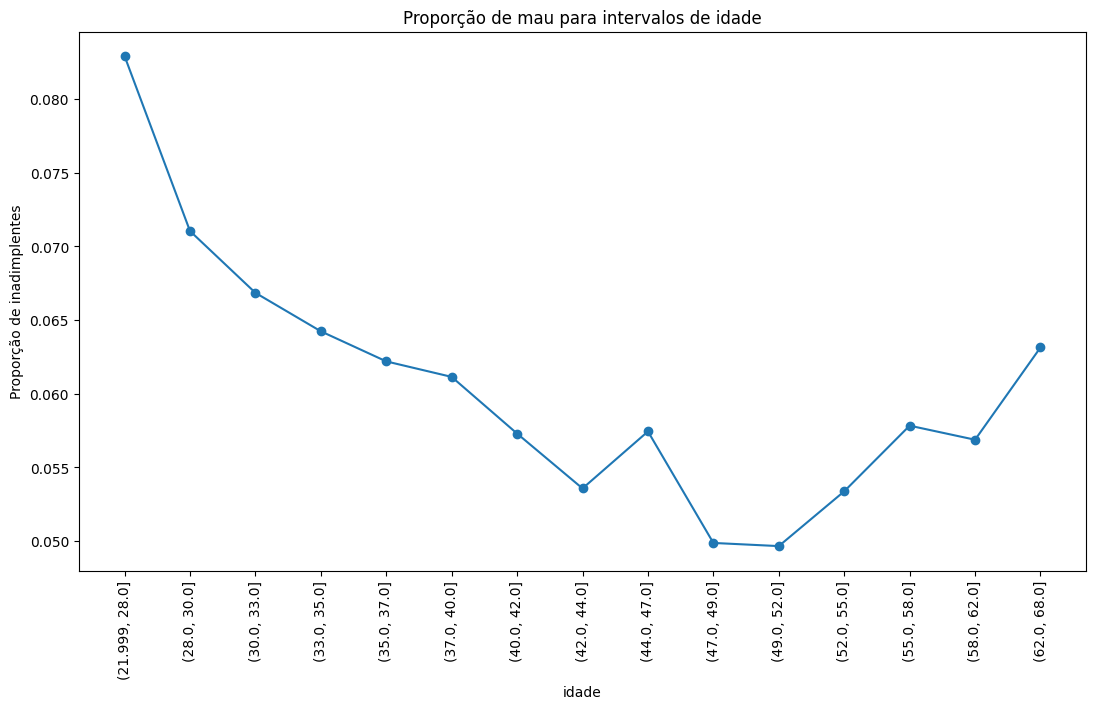

In [20]:
# Cria uma figura e um eixo (ax) para o gráfico
# Define o tamanho da figura como 13 de largura e 7 de altura
fig, ax = plt.subplots(figsize=(13, 7))

# Divide a variável 'idade' em 15 categorias baseadas em quantis (bins)
# - `pd.qcut(...)`: cria categorias (intervalos) que contêm quantidades aproximadamente iguais de dados
# - `retbins=True`: retorna também os limites dos bins (intervalos de idade)
cat_1, bins = pd.qcut(df_train['idade'], 15, retbins=True)

# Agrupa os dados do DataFrame por essas categorias de idade criadas (cat_1)
df_1 = df_train.groupby(cat_1)

# Calcula a proporção média de inadimplentes ('mau') para cada intervalo de idade
biv = df_1['mau'].mean()

# Plota o gráfico de linha com os valores calculados
# - `biv.plot.line(marker='o')`: cria uma linha com marcadores ('o') nos pontos representando os intervalos de idade
ax = biv.plot.line(marker='o')

# Define o rótulo do eixo Y indicando que representa a proporção de inadimplentes
ax.set_ylabel("Proporção de inadimplentes")

# Ajusta os rótulos do eixo X para exibir os intervalos de idade (categorias)
# - `plt.xticks(...)`: define os rótulos do eixo X como os valores dos intervalos e rotaciona os rótulos em 90 graus
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)

# Define o título do gráfico explicando o que está sendo visualizado
ax.set_title('Proporção de mau para intervalos de idade')


Text(0.5, 1.0, 'Proporção de mau para intervalos de tempo de emprego')

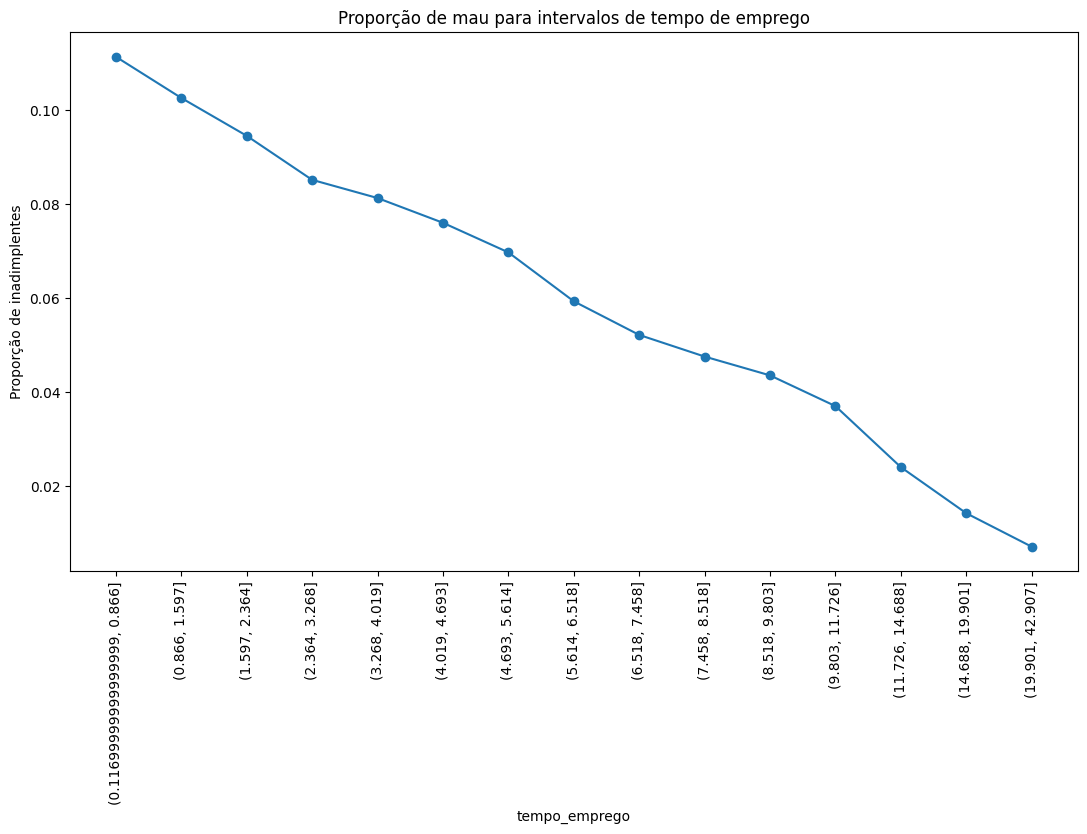

In [21]:
# Cria uma figura e um eixo (ax) para o gráfico
# Define o tamanho da figura como 13 de largura e 7 de altura
fig, ax = plt.subplots(figsize=(13, 7))

# Divide a variável 'tempo_emprego' em 15 categorias (bins) baseadas em quantis
# - `pd.qcut(...)`: cria categorias (intervalos) com quantidades aproximadamente iguais de dados
# - `retbins=True`: retorna também os limites dos bins (intervalos de tempo de emprego)
cat_1, bins = pd.qcut(df_train['tempo_emprego'], 15, retbins=True)

# Agrupa os dados do DataFrame por essas categorias de tempo de emprego criadas (cat_1)
df_1 = df_train.groupby(cat_1)

# Calcula a proporção média de inadimplentes ('mau') para cada intervalo de tempo de emprego
biv = df_1['mau'].mean()

# Plota o gráfico de linha com os valores calculados
# - `biv.plot.line(marker='o')`: cria uma linha com marcadores ('o') nos pontos representando os intervalos de tempo
ax = biv.plot.line(marker='o')

# Define o rótulo do eixo Y indicando que representa a proporção de inadimplentes
ax.set_ylabel("Proporção de inadimplentes")

# Ajusta os rótulos do eixo X para exibir os intervalos de tempo de emprego (categorias)
# - `plt.xticks(...)`: define os rótulos do eixo X como os valores dos intervalos e rotaciona os rótulos em 90 graus
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)

# Define o título do gráfico explicando o que está sendo visualizado
ax.set_title('Proporção de mau para intervalos de tempo de emprego')


Text(0.5, 1.0, 'Proporção de mau para intervalos de renda')

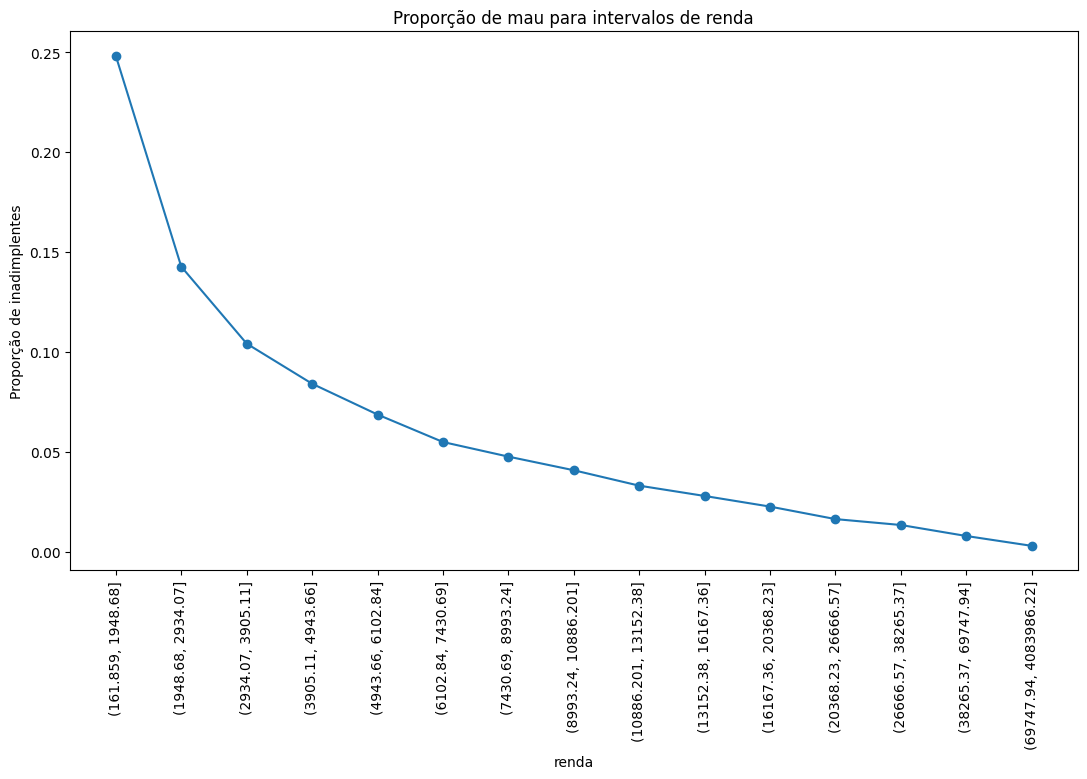

In [22]:
# Cria uma figura e um eixo (ax) para o gráfico
# Define o tamanho da figura como 13 de largura e 7 de altura
fig, ax = plt.subplots(figsize=(13, 7))

# Divide a variável 'renda' em 15 categorias (bins) baseadas em quantis
# - `pd.qcut(...)`: cria categorias (intervalos) contendo aproximadamente a mesma quantidade de dados
# - `retbins=True`: retorna também os limites dos bins (intervalos de renda)
cat_1, bins = pd.qcut(df_train['renda'], 15, retbins=True)

# Agrupa os dados do DataFrame por essas categorias de renda criadas (cat_1)
df_1 = df_train.groupby(cat_1)

# Calcula a proporção média de inadimplentes ('mau') para cada intervalo de renda
biv = df_1['mau'].mean()

# Plota o gráfico de linha com os valores calculados
# - `biv.plot.line(marker='o')`: cria uma linha com marcadores ('o') nos pontos representando os intervalos de renda
ax = biv.plot.line(marker='o')

# Define o rótulo do eixo Y indicando que representa a proporção de inadimplentes
ax.set_ylabel("Proporção de inadimplentes")

# Ajusta os rótulos do eixo X para exibir os intervalos de renda (categorias)
# - `plt.xticks(...)`: define os rótulos do eixo X como os valores dos intervalos e rotaciona os rótulos em 90 graus
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)

# Define o título do gráfico explicando o que está sendo visualizado
ax.set_title('Proporção de mau para intervalos de renda')


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [23]:
# Converte a coluna 'mau' para o tipo inteiro de 64 bits (int64)
# Isso pode ser útil para garantir consistência nos dados, especialmente se 'mau' foi originalmente armazenado como outro tipo (ex.: float ou object)
df_train['mau'] = df_train.mau.astype('int64')

# Remove as colunas 'data_ref', 'index' e 'Mes' do DataFrame
# - `columns=['data_ref', 'index', 'Mes']`: especifica as colunas a serem removidas
# - `inplace=True`: aplica a modificação diretamente ao DataFrame, sem criar uma cópia
df_train.drop(columns=['data_ref', 'index', 'Mes'], inplace=True)

# Exibe informações sobre o DataFrame atualizado
# - Mostra o número de colunas, tipos de dados, memória usada, e quantos valores não nulos existem em cada coluna
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


In [24]:
# Substitui valores ausentes (missing) na coluna 'tempo_emprego' pela média dos valores existentes
# - `fillna(value=...)`: substitui valores ausentes (NaN) pelo valor especificado
# - `df_train['tempo_emprego'].mean()`: calcula a média dos valores não nulos da coluna 'tempo_emprego'
# - `inplace=True`: aplica a substituição diretamente no DataFrame, sem criar uma cópia
df_train['tempo_emprego'].fillna(value=df_train['tempo_emprego'].mean(), inplace=True)


In [25]:
# Cria um DataFrame chamado 'metadados' que armazena informações sobre as colunas do DataFrame 'df_train'
# - `df_train.dtypes`: retorna os tipos de dados de cada coluna no DataFrame
# - `columns=['dtype']`: define o nome da coluna no DataFrame de metadados como 'dtype' (tipo de dado)
metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])

# Adiciona uma nova coluna ao DataFrame de metadados chamada 'nmissing'
# - `df_train.isna().sum()`: conta o número de valores ausentes (NaN) em cada coluna do DataFrame
metadados['nmissing'] = df_train.isna().sum()

# Adiciona outra coluna chamada 'valores_unicos' que armazena o número de valores únicos em cada coluna
# - `df_train.nunique()`: retorna a contagem de valores únicos em cada coluna
metadados['valores_unicos'] = df_train.nunique()

# Adiciona uma coluna chamada 'papel' e define o valor padrão como 'covariavel'
# Isso indica que, por padrão, todas as colunas são consideradas como variáveis independentes (covariáveis)
metadados['papel'] = 'covariavel'

# Modifica o valor na linha correspondente à coluna 'mau' para 'resposta'
# - `metadados.loc['mau', 'papel']`: seleciona a célula na linha 'mau' e coluna 'papel'
# - A coluna 'mau' é a variável dependente (ou alvo), então seu papel é definido como 'resposta'
metadados.loc['mau', 'papel'] = 'resposta'

# Exibe o DataFrame de metadados
metadados


,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [26]:
# Itera sobre cada variável que foi classificada como 'covariavel' no DataFrame 'metadados'
for var in metadados[metadados.papel == 'covariavel'].index:

    # Verifica se a variável tem mais de 10 valores únicos
    if metadados.loc[var, 'valores_unicos'] > 10:
        # Se a variável tiver mais de 10 valores únicos, é considerada contínua
        # Aplica a função `IV` usando `pd.qcut` para dividir os dados em 5 bins (quintis)
        # - `pd.qcut(..., duplicates='drop')`: evita duplicação de bins caso não seja possível dividir igualmente
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var], 5, duplicates='drop'), df_train.mau)
    else:
        # Se a variável tiver 10 ou menos valores únicos, é considerada categórica
        # Aplica a função `IV` diretamente na variável
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)

# Exibe o DataFrame 'metadados' atualizado com a nova coluna 'IV' (Information Value)
metadados


,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.001689
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,0,3005,covariavel,0.283956


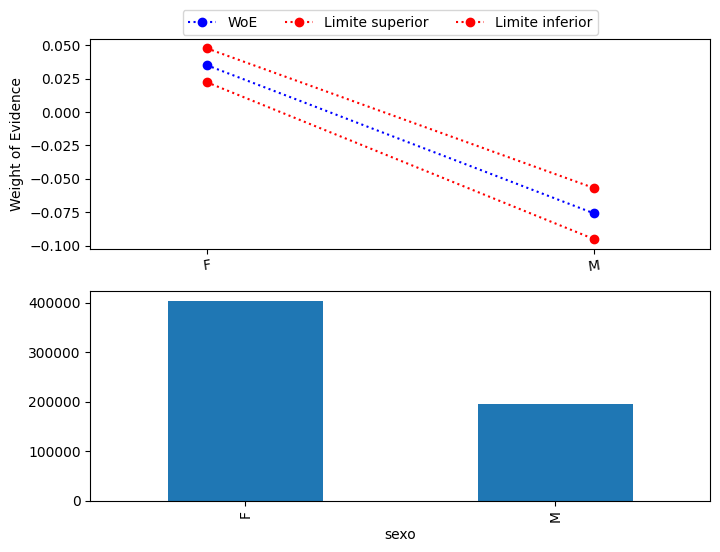

In [27]:
# Chama a função 'biv_discreta' para realizar uma análise bivariada da variável categórica 'sexo' no DataFrame 'df_train'
# - 'sexo': a variável categórica que será analisada
# - 'df_train': o DataFrame contendo os dados
# A função provavelmente calcula métricas como a proporção de inadimplentes ('mau') em relação às categorias da variável 'sexo'
biv_discreta('sexo', df_train);


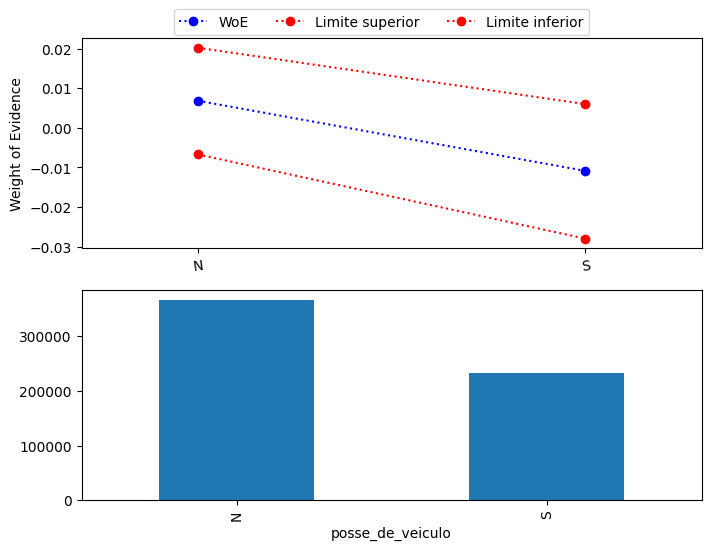

In [28]:
# Chama a função 'biv_discreta' para realizar uma análise bivariada da variável categórica 'posse_de_veiculo' no DataFrame 'df_train'
# - 'posse_de_veiculo': a variável categórica a ser analisada (indica se o cliente possui ou não um veículo)
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisa a relação entre a posse de veículo e a variável-alvo 'mau', provavelmente calculando métricas como
# proporção de inadimplentes, erro-padrão, e outras estatísticas relacionadas.
biv_discreta('posse_de_veiculo', df_train);


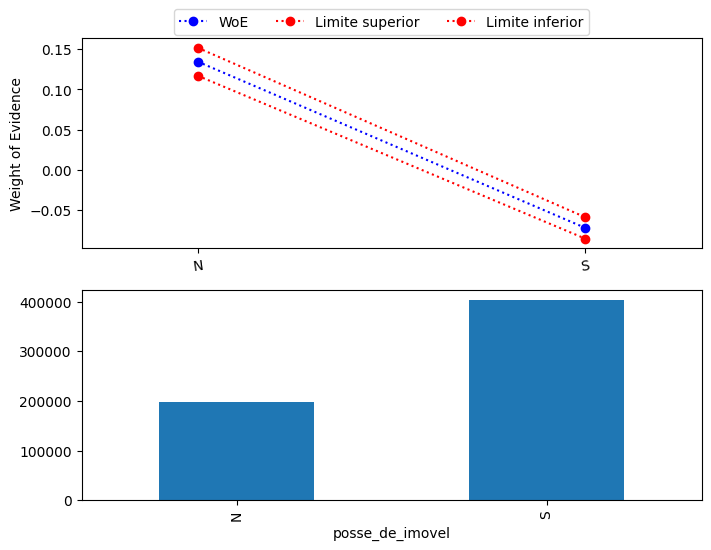

In [29]:
# Chama a função 'biv_discreta' para realizar uma análise bivariada da variável categórica 'posse_de_imovel' no DataFrame 'df_train'
# - 'posse_de_imovel': a variável categórica a ser analisada (indica se o cliente possui ou não um imóvel)
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisa a relação entre a posse de imóvel e a variável-alvo 'mau', provavelmente calculando métricas como
# proporção de inadimplentes, erro-padrão, WoE (Weight of Evidence), e IV (Information Value).
biv_discreta('posse_de_imovel', df_train);


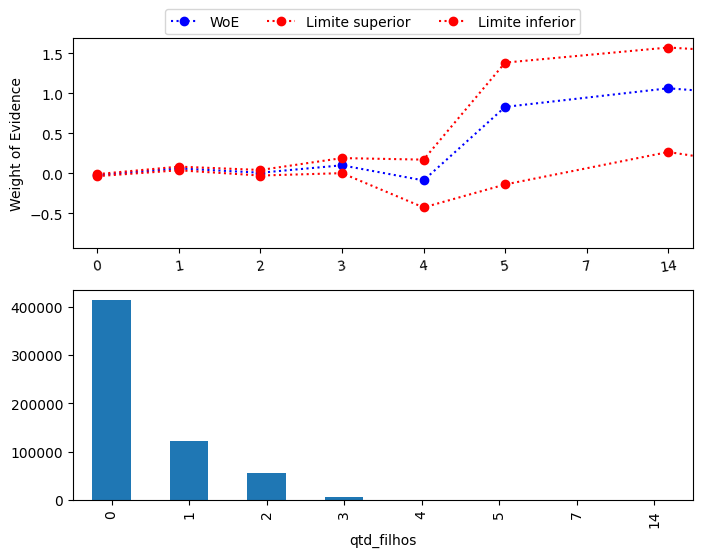

In [30]:
# Chama a função 'biv_discreta' para realizar uma análise bivariada da variável categórica 'qtd_filhos' no DataFrame 'df_train'
# - 'qtd_filhos': a variável categórica a ser analisada (indica a quantidade de filhos dos clientes)
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisa a relação entre a quantidade de filhos e a variável-alvo 'mau', calculando métricas como:
# proporção de inadimplentes, erro-padrão, WoE (Weight of Evidence), e IV (Information Value).
biv_discreta('qtd_filhos', df_train);


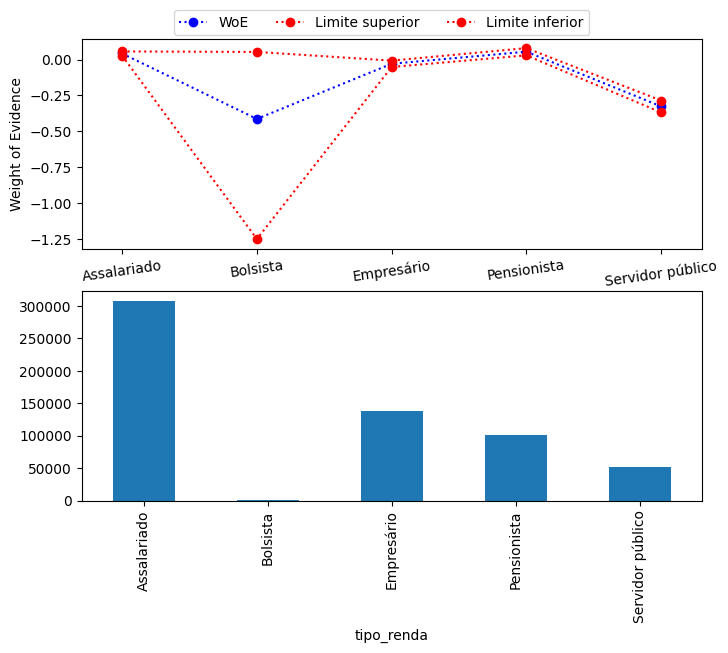

In [31]:
# Chama a função 'biv_discreta' para realizar uma análise bivariada da variável categórica 'tipo_renda' no DataFrame 'df_train'
# - 'tipo_renda': a variável categórica a ser analisada (indica o tipo de renda do cliente, como "assalariado", "autônomo", etc.)
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisa a relação entre as categorias de 'tipo_renda' e a variável-alvo 'mau', calculando métricas como:
# proporção de inadimplentes, erro-padrão, WoE (Weight of Evidence), e IV (Information Value).
biv_discreta('tipo_renda', df_train);


0.009634301334170859

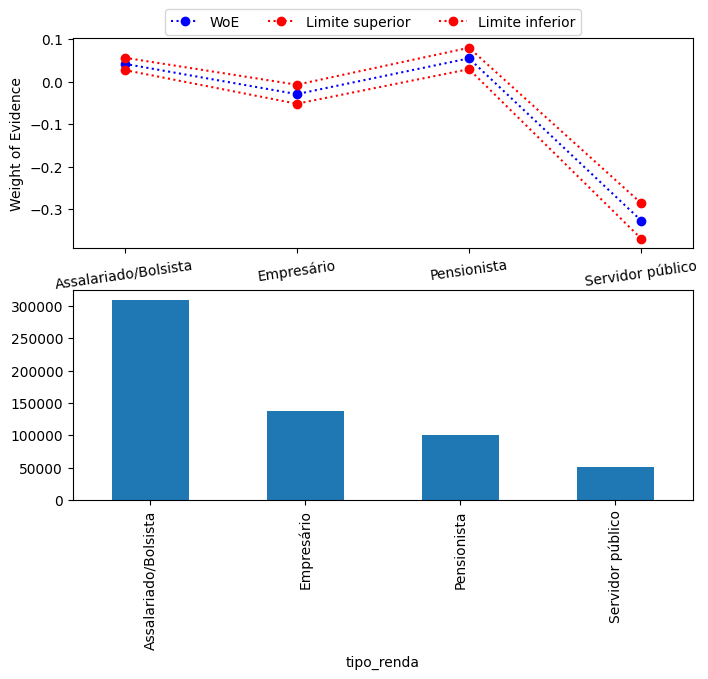

In [32]:
# Agrupa algumas categorias da variável 'tipo_renda' para simplificar a análise
# - A categoria 'Assalariado' e 'Bolsista' são combinadas em uma única categoria: 'Assalariado/Bolsista'
# - `df_train.tipo_renda.replace(...)`: substitui os valores das categorias especificadas no dicionário
# - `inplace=True`: aplica a modificação diretamente no DataFrame, sem criar uma cópia
df_train.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista',
                             'Bolsista': 'Assalariado/Bolsista'},
                             inplace=True)

# Realiza a análise bivariada da variável agrupada 'tipo_renda' em relação à variável-alvo 'mau'
biv_discreta('tipo_renda', df_train);

# Calcula o Information Value (IV) da variável agrupada 'tipo_renda' em relação à variável-alvo 'mau'
IV(df_train.tipo_renda, df_train.mau)


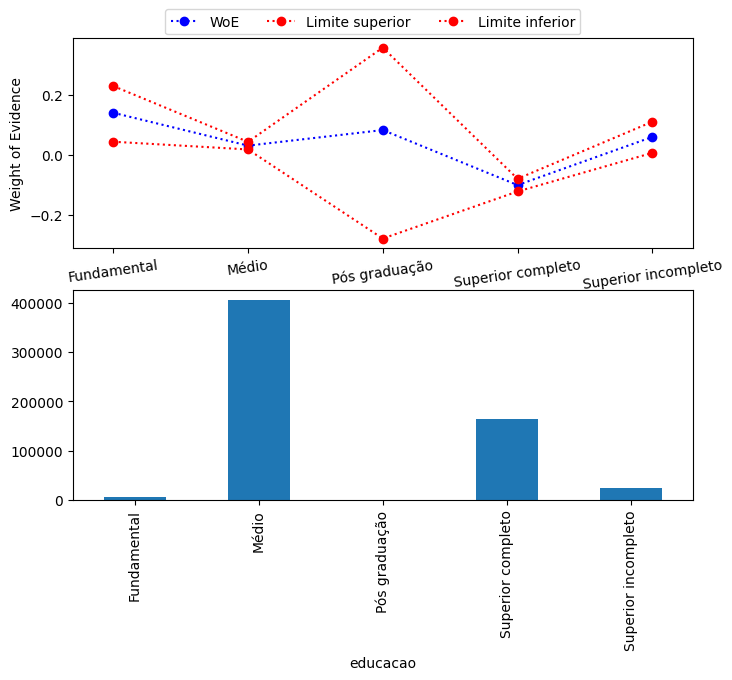

In [33]:
# Chama a função 'biv_discreta' para realizar uma análise bivariada da variável categórica 'educacao' no DataFrame 'df_train'
# - 'educacao': a variável categórica a ser analisada (indica o nível de escolaridade dos clientes, como "Ensino Médio", "Graduação", etc.)
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisa a relação entre as categorias de 'educacao' e a variável-alvo 'mau', calculando métricas como:
# proporção de inadimplentes, erro-padrão, WoE (Weight of Evidence), e IV (Information Value).
biv_discreta('educacao', df_train);


0.0034801108923340892

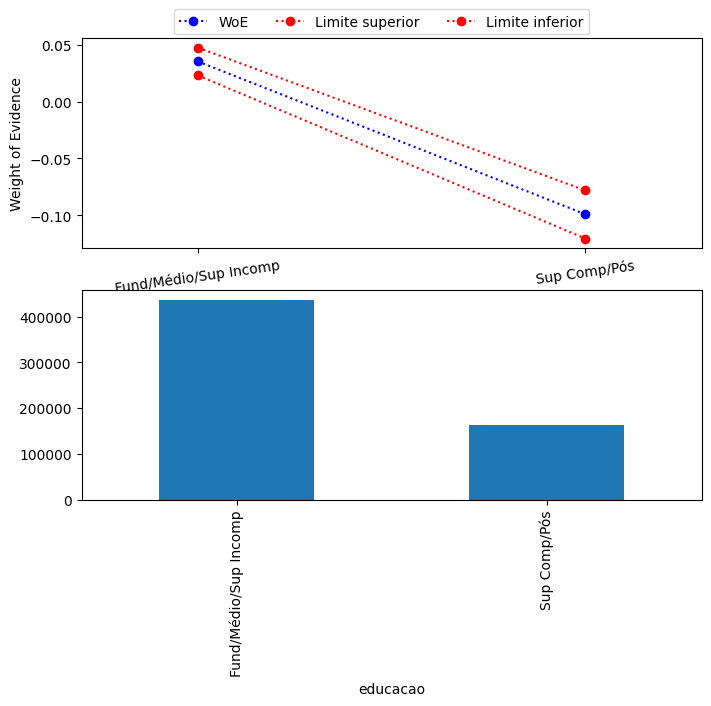

In [34]:
# Agrupa algumas categorias da variável 'educacao' para simplificar a análise e reduzir a granularidade
# - 'Fundamental', 'Médio' e 'Superior incompleto' são combinados em uma única categoria: 'Fund/Médio/Sup Incomp'
# - 'Superior completo' e 'Pós graduação' são combinados em outra categoria: 'Sup Comp/Pós'
# - `df_train.educacao.replace(...)`: substitui as categorias especificadas no dicionário pelos valores agrupados
# - `inplace=True`: aplica a modificação diretamente no DataFrame, sem criar uma cópia
df_train.educacao.replace({'Fundamental': 'Fund/Médio/Sup Incomp',
                           'Médio': 'Fund/Médio/Sup Incomp',
                           'Superior incompleto': 'Fund/Médio/Sup Incomp',
                           'Superior completo': 'Sup Comp/Pós',
                           'Pós graduação': 'Sup Comp/Pós'},
                          inplace=True)

# Realiza a análise bivariada da variável agrupada 'educacao' em relação à variável-alvo 'mau'
# - Examina como as categorias agrupadas de 'educacao' se relacionam com a inadimplência
biv_discreta('educacao', df_train);

# Calcula o Information Value (IV) para a variável agrupada 'educacao' em relação à variável-alvo 'mau'
# - Avalia o poder preditivo da variável 'educacao' agrupada
IV(df_train.educacao, df_train.mau)


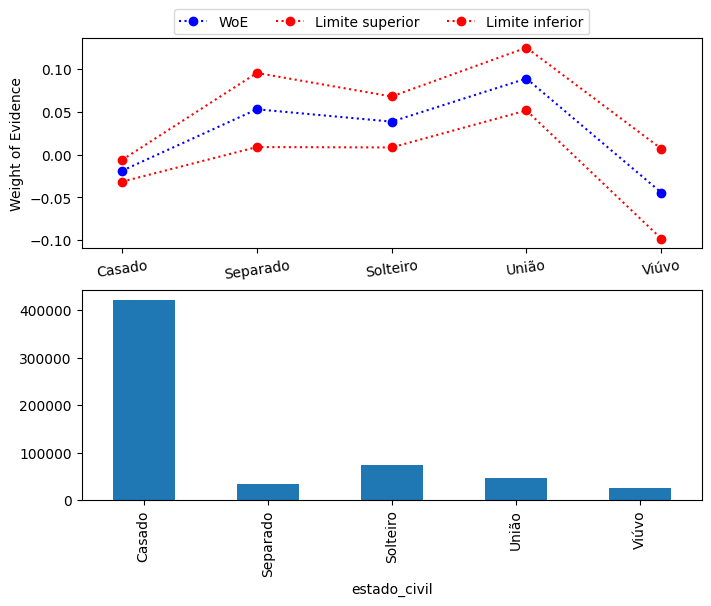

In [35]:
# Chama a função 'biv_discreta' para realizar uma análise bivariada da variável categórica 'estado_civil' no DataFrame 'df_train'
# - 'estado_civil': a variável categórica a ser analisada (representa o estado civil do cliente, como "Solteiro", "Casado", etc.)
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisa a relação entre as categorias de 'estado_civil' e a variável-alvo 'mau', calculando métricas como:
# proporção de inadimplentes, erro-padrão, WoE (Weight of Evidence), e IV (Information Value).
biv_discreta('estado_civil', df_train);


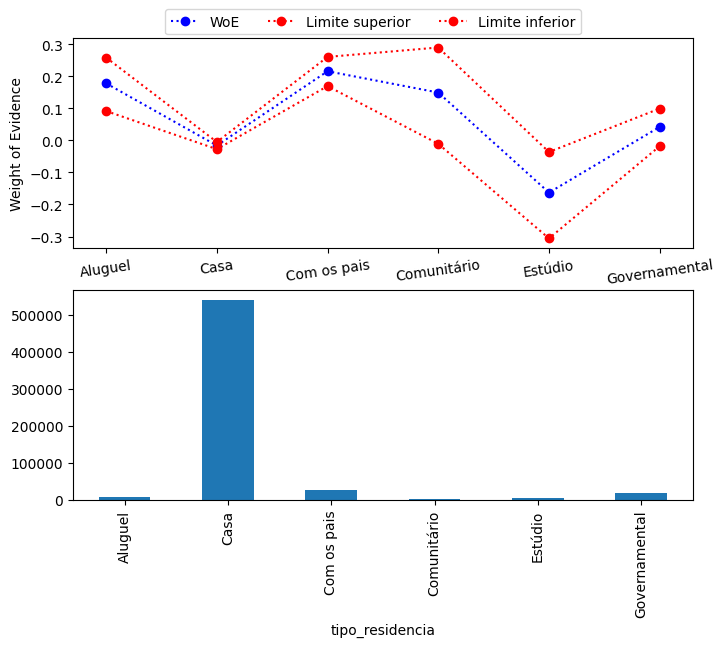

In [36]:
# Chama a função 'biv_discreta' para realizar uma análise bivariada da variável categórica 'tipo_residencia' no DataFrame 'df_train'
# - 'tipo_residencia': a variável categórica a ser analisada (indica o tipo de residência dos clientes, como "Alugada", "Própria", etc.)
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisa a relação entre as categorias de 'tipo_residencia' e a variável-alvo 'mau', calculando métricas como:
# proporção de inadimplentes, erro-padrão, WoE (Weight of Evidence), e IV (Information Value).
biv_discreta('tipo_residencia', df_train);


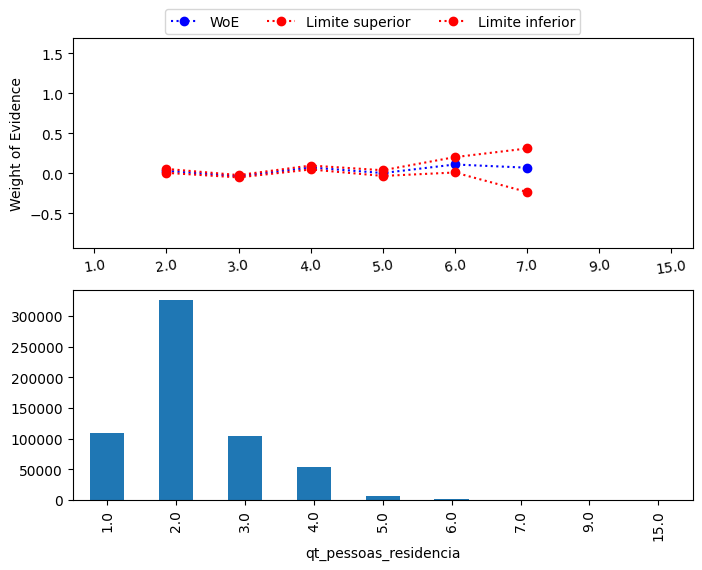

In [37]:
# Chama a função 'biv_discreta' para realizar uma análise bivariada da variável categórica 'qt_pessoas_residencia' no DataFrame 'df_train'
# - 'qt_pessoas_residencia': a variável categórica a ser analisada (indica a quantidade de pessoas na residência do cliente)
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisa a relação entre as categorias de 'qt_pessoas_residencia' e a variável-alvo 'mau', calculando métricas como:
# proporção de inadimplentes, erro-padrão, WoE (Weight of Evidence), e IV (Information Value).
biv_discreta('qt_pessoas_residencia', df_train);


In [46]:
def biv_continua(var, ncat, df):
    """
    Realiza uma análise bivariada de uma variável contínua em relação à variável-alvo 'mau'.

    Parâmetros:
    - var: Nome da variável contínua a ser analisada.
    - ncat: Número de categorias (bins) em que a variável será dividida.
    - df: DataFrame contendo os dados.

    Retorna:
    - Gráficos de Weight of Evidence (WoE) e contagem de observações por intervalo.
    """

    # Cria uma nova variável 'bom' que representa os clientes não inadimplentes (1 - 'mau')
    df['bom'] = 1 - df.mau

    # Divide a variável contínua em ncat categorias (bins) aproximadamente iguais
    # - `pd.qcut(...)`: cria bins com quantidades aproximadamente iguais de observações
    # - `retbins=True`: retorna os limites dos bins usados para segmentação
    # - `precision=0`: arredonda os valores dos bins
    # - `duplicates='drop'`: evita a criação de bins duplicados caso existam valores repetidos
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')

    # Agrupa os dados pelo intervalo (categoria) criado para a variável contínua
    g = df.groupby(cat_srs)

    # Criação do DataFrame 'biv' contendo estatísticas de cada intervalo da variável
    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),      # Soma de clientes bons (não inadimplentes) em cada bin
        'qt_mau': g['mau'].sum(),      # Soma de clientes maus (inadimplentes) em cada bin
        'mau': g['mau'].mean(),        # Proporção de inadimplentes em cada bin
        var: g[var].mean(),            # Média da variável contínua em cada bin
        'cont': g[var].count()         # Quantidade de registros em cada bin
    })

    # Cálculo do erro-padrão da proporção de inadimplentes em cada bin
    biv['ep'] = (biv.mau * (1 - biv.mau) / biv.cont) ** 0.5

    # Cálculo dos limites de confiança superior e inferior para a proporção de inadimplentes
    biv['mau_sup'] = biv.mau + t.ppf(0.975, biv.cont - 1) * biv.ep  # Limite superior
    biv['mau_inf'] = biv.mau - t.ppf(0.025, biv.cont - 1) * biv.ep  # Limite inferior

    # Cálculo da função logit para cada bin
    biv['logit'] = np.log(biv.mau / (1 - biv.mau))  # Logit da proporção de inadimplentes
    biv['logit_sup'] = np.log(biv.mau_sup / (1 - biv.mau_sup))  # Logit do limite superior
    biv['logit_inf'] = np.log(biv.mau_inf / (1 - biv.mau_inf))  # Logit do limite inferior

    # Cálculo do Weight of Evidence (WoE)
    tx_mau_geral = df.mau.mean()  # Taxa geral de inadimplentes no DataFrame
    woe_geral = np.log(tx_mau_geral / (1 - tx_mau_geral))  # WoE geral

    # WoE de cada bin comparado ao WoE geral
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    # Criação dos gráficos
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    # Gráfico de WoE com limites superior e inferior
    ax[0].plot(biv[var], biv.woe, ':bo', label='WoE')  # Linha azul para WoE
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='Limite Superior')  # Pontos vermelhos para limite superior
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='Limite Inferior')  # Pontos vermelhos para limite inferior

    # Configuração do gráfico de WoE
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(0.83, 1.17), ncol=3)

    # Número de categorias geradas
    num_cat = biv.shape[0]

    # Gráfico de barras para a contagem de observações em cada bin
    ax[1] = biv.cont.plot.bar()

    return None  # A função não retorna um DataFrame, apenas gera os gráficos


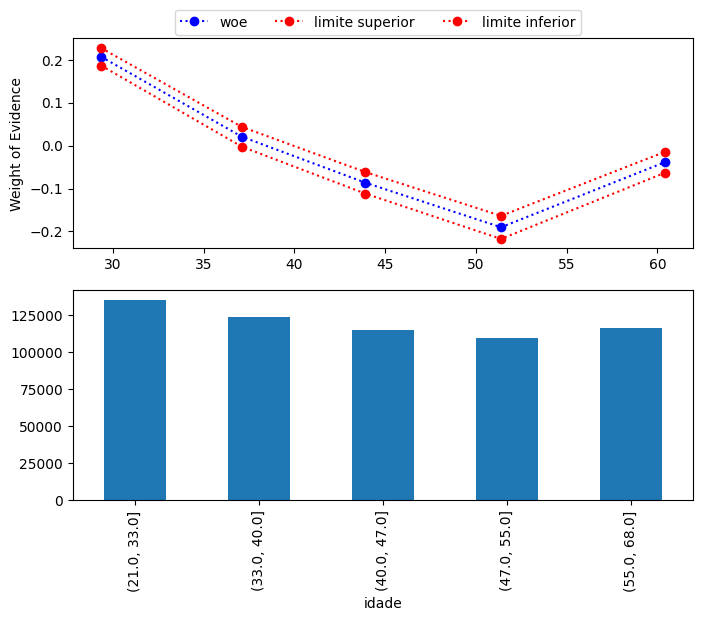

In [45]:
# Chama a função 'biv_continua' para realizar uma análise bivariada de uma variável contínua, 'idade', no DataFrame 'df_train'
# - 'idade': a variável contínua a ser analisada (representa a idade dos clientes)
# - 5: o número de categorias (bins) em que a variável 'idade' será dividida
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisa a relação entre os intervalos de idade (bins) e a variável-alvo 'mau', calculando métricas como:
# proporção de inadimplentes, erro-padrão, WoE (Weight of Evidence), e IV (Information Value).
biv_continua('idade', 5, df_train)

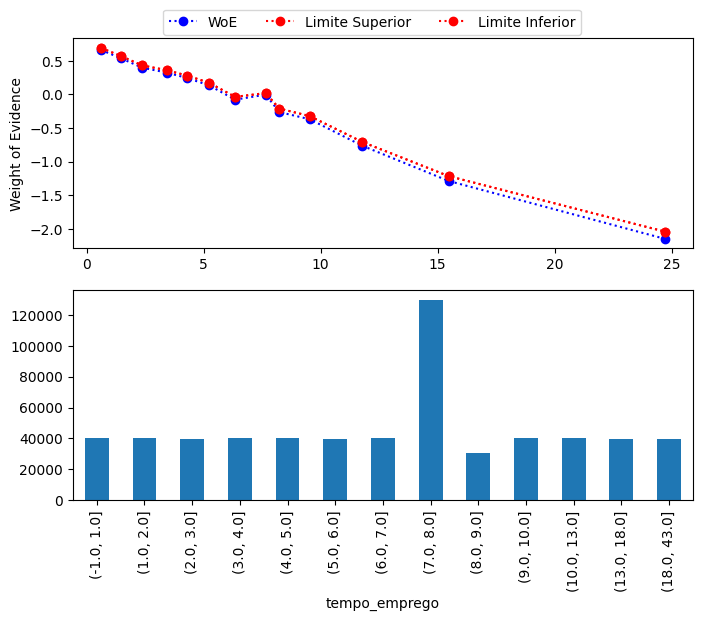

In [47]:
# Chama a função 'biv_continua' para realizar uma análise bivariada da variável contínua 'tempo_emprego' no DataFrame 'df_train'
# - 'tempo_emprego': variável contínua a ser analisada (indica o tempo de emprego do cliente)
# - 15: número de categorias (bins) em que a variável será dividida
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisará a relação entre os intervalos de 'tempo_emprego' e a variável-alvo 'mau', gerando:
# - Proporção de inadimplentes por faixa de 'tempo_emprego'
# - Cálculo do erro-padrão e limites superior e inferior
# - Cálculo do Weight of Evidence (WoE)
# - Gráficos para visualização dos resultados
biv_continua('tempo_emprego', 15, df_train)


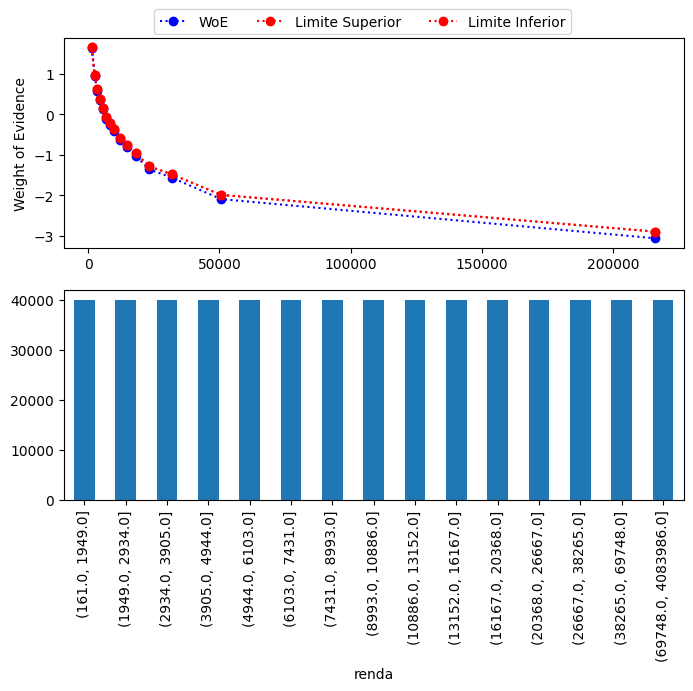

In [48]:
# Chama a função 'biv_continua' para realizar uma análise bivariada da variável contínua 'renda' no DataFrame 'df_train'
# - 'renda': variável contínua a ser analisada (indica a renda dos clientes)
# - 15: número de categorias (bins) em que a variável será dividida
# - 'df_train': o DataFrame contendo os dados de treino
# A função analisará a relação entre os intervalos de 'renda' e a variável-alvo 'mau', gerando:
# - Proporção de inadimplentes por faixa de 'renda'
# - Cálculo do erro-padrão e limites superior e inferior
# - Cálculo do Weight of Evidence (WoE)
# - Gráficos para visualização dos resultados
biv_continua('renda', 15, df_train)


In [49]:
# Define a fórmula para o modelo de regressão logística
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda +
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
'''

# Ajusta um modelo de regressão logística usando a fórmula definida
# - `smf.glm(...)`: Especifica um modelo de regressão generalizada (GLM)
# - `formula`: Define a variável dependente ('mau') e as variáveis explicativas (preditores)
# - `data=df_train`: Utiliza o DataFrame 'df_train' como base de dados para o modelo
# - `family=sm.families.Binomial()`: Indica que o modelo é binomial (regressão logística)
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibe o resumo do modelo ajustado, incluindo coeficientes, erros-padrão e estatísticas de ajuste
rl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599979
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Tue, 28 Jan 2025   Deviance:                   2.4965e+05
Time:                        06:15:32   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4189      0.053    -26.825      0.000      -1.523      -1.315
sexo[T.M]                           -0.1255      0.013     -9.567      0.000      -0.151      -0.100
posse_de_veiculo[T.S]                0.0313      0.012      2.529      0.011       0.007       0.056
posse_de_imovel[T.S]                -0.0847      0.012     -7.178      0.000      -0.108      -0.062
tipo_renda[T.Empresário]            -0.0545      0.014     -3.900      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]           -0.0411      0.020     -2.032      0.042      -0.081      -0.001
tipo_renda[T.Servidor público]      -0.0330      0.023     -1.421      0.155      -0.079       0.013
educacao[T.Sup Comp/Pós]            -0.0566      0.013     -4.326      0.000      -0.082      -0.031
estado_civil[T.Separado]             0.0374      0.024      1.574      0.116      -0.009       0.084
estado_civil[T.Solteiro]             0.0054      0.017      0.311      0.756      -0.029       0.039
estado_civil[T.União]                0.0472      0.020      2.322      0.020       0.007       0.087
estado_civil[T.Viúvo]               -0.0346      0.029     -1.192      0.233      -0.092       0.022
tipo_residencia[T.Casa]             -0.0879      0.044     -1.995      0.046      -0.174      -0.002
tipo_residencia[T.Com os pais]      -0.0731      0.050     -1.475      0.140      -0.170       0.024
tipo_residencia[T.Comunitário]      -0.1403      0.089     -1.572      0.116      -0.315       0.035
tipo_residencia[T.Estúdio]          -0.0327      0.082     -0.397      0.691      -0.194       0.129
tipo_residencia[T.Governamental]    -0.0834      0.053     -1.565      0.118      -0.188       0.021
qtd_filhos                           0.0036      0.008      0.448      0.654      -0.012       0.019
idade                                0.0003      0.001      0.394      0.693      -0.001       0.002
tempo_emprego                       -0.0236      0.002    -13.100      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -93.691      0.000      -0.000   -9.96e-05
====================================================================================================
"""

In [50]:
# Define a fórmula para o modelo de regressão logística
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

# Ajusta um modelo de regressão logística usando a fórmula definida
# - `smf.glm(...)`: Especifica um modelo de regressão generalizada (GLM)
# - `formula`: Define a variável dependente ('mau') e as variáveis explicativas (preditoras)
# - `data=df_train`: Utiliza o DataFrame 'df_train' como base de dados para o modelo
# - `family=sm.families.Binomial()`: Indica que o modelo é binomial (regressão logística)
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibe o resumo do modelo ajustado, incluindo coeficientes, erros-padrão e estatísticas de ajuste
rl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Tue, 28 Jan 2025   Deviance:                   2.4969e+05
Time:                        06:48:01   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

In [51]:
# Define a fórmula para o modelo de regressão logística binária
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

# Ajusta um modelo de regressão logística usando a fórmula definida
# - `smf.glm(...)`: Especifica um modelo de regressão generalizada (GLM)
# - `formula`: Define a variável dependente ('mau') e as variáveis explicativas (preditores)
# - `data=df_train`: Utiliza o DataFrame 'df_train' como base de dados para o modelo
# - `family=sm.families.Binomial()`: Indica que o modelo é binomial (regressão logística), adequado para previsão de variáveis binárias
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibe o resumo do modelo ajustado, incluindo coeficientes, erros-padrão, estatísticas de ajuste e significância das variáveis
rl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Tue, 28 Jan 2025   Deviance:                   2.4969e+05
Time:                        06:48:49   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

In [52]:
# Define a fórmula para o modelo de regressão logística binária
# Agora aplicamos uma transformação logarítmica na variável 'renda' para reduzir o efeito de outliers
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + np.log(renda)
'''

# Ajusta um modelo de regressão logística usando a fórmula definida
# - `smf.glm(...)`: Especifica um modelo de regressão generalizada (GLM)
# - `formula`: Define a variável dependente ('mau') e as variáveis explicativas (preditores)
# - `data=df_train`: Utiliza o DataFrame 'df_train' como base de dados para o modelo
# - `family=sm.families.Binomial()`: Indica que o modelo é binomial (regressão logística), adequado para prever variáveis binárias
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibe o resumo do modelo ajustado, incluindo coeficientes, erros-padrão, estatísticas de ajuste e significância das variáveis
rl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Tue, 28 Jan 2025   Deviance:                   2.4055e+05
Time:                        06:49:55   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05720
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.9194      0.051    115.829      0.000       5.819       6.020
sexo[T.M]                   -0.0018      0.012     -0.149      0.882      -0.026       0.022
posse_de_imovel[T.S]        -0.0175      0.012     -1.494      0.135      -0.040       0.005
educacao[T.Sup Comp/Pós]    -0.0056      0.013     -0.430      0.667      -0.031       0.020
tempo_emprego               -0.0010      0.002     -0.610      0.542      -0.004       0.002
np.log(renda)               -0.9881      0.007   -149.914      0.000      -1.001      -0.975
============================================================================================
"""

In [53]:
# Define a fórmula para o modelo de regressão logística binária
# Neste caso, usamos apenas a variável 'renda', aplicando uma transformação logarítmica para reduzir o impacto de outliers
formula = '''
    mau ~ np.log(renda)
'''

# Ajusta um modelo de regressão logística usando a fórmula definida
# - `smf.glm(...)`: Especifica um modelo de regressão generalizada (GLM)
# - `formula`: Define a variável dependente ('mau') e a variável explicativa ('np.log(renda)')
# - `data=df_train`: Utiliza o DataFrame 'df_train' como base de dados para o modelo
# - `family=sm.families.Binomial()`: Indica que o modelo é binomial (regressão logística), adequado para prever variáveis binárias
rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

# Exibe o resumo do modelo ajustado, incluindo coeficientes, erros-padrão, estatísticas de ajuste e significância da variável
rl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2028e+05
Date:                Tue, 28 Jan 2025   Deviance:                   2.4055e+05
Time:                        06:50:39   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05719
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.9239      0.049    121.382      0.000       5.828       6.020
np.log(renda)    -0.9908      0.006   -169.858      0.000      -1.002      -0.979
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [54]:
# Adiciona uma coluna 'score' ao DataFrame 'df_train'
# - 'rl.predict(df_train)': Gera as previsões (probabilidades de inadimplência) do modelo ajustado
# - Essas previsões são usadas para avaliar o desempenho do modelo
df_train['score'] = rl.predict(df_train)

# Calcula a acurácia do modelo
# - `metrics.accuracy_score`: Compara os valores reais ('mau') com os valores preditos (convertidos para classes binárias)
# - `df_train.score > .068`: Considera um limite de 6.8% para classificar como inadimplente (1) ou não inadimplente (0)
acc = metrics.accuracy_score(df_train.mau, df_train.score > .068)

# Calcula a AUC (Área Sob a Curva ROC)
# - `metrics.roc_curve`: Calcula as taxas de falso positivo (FPR), verdadeiro positivo (TPR) e os thresholds
# - `metrics.auc`: Calcula a área sob a curva ROC com base em FPR e TPR
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)

# Calcula o índice Gini
# - Gini é uma métrica derivada da AUC: Gini = 2 * AUC - 1
gini = 2 * auc - 1

# Calcula o KS (Kolmogorov-Smirnov)
# - `ks_2samp`: Realiza o teste KS para medir a maior diferença cumulativa entre as distribuições de escores dos inadimplentes e adimplentes
ks = ks_2samp(
    df_train.loc[df_train.mau == 1, 'score'],  # Escores para inadimplentes
    df_train.loc[df_train.mau != 1, 'score']   # Escores para adimplentes
).statistic

# Exibe as métricas de desempenho
# - 'Acurácia': Percentual de classificações corretas
# - 'AUC': Área sob a curva ROC, indicando a capacidade de separação do modelo
# - 'GINI': Métrica derivada da AUC para avaliar o poder discriminatório do modelo
# - 'KS': Diferença máxima entre as distribuições de escores dos grupos (inadimplentes e adimplentes)
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 71.9% 
AUC: 77.0% 
GINI: 54.0%
KS: 39.9%


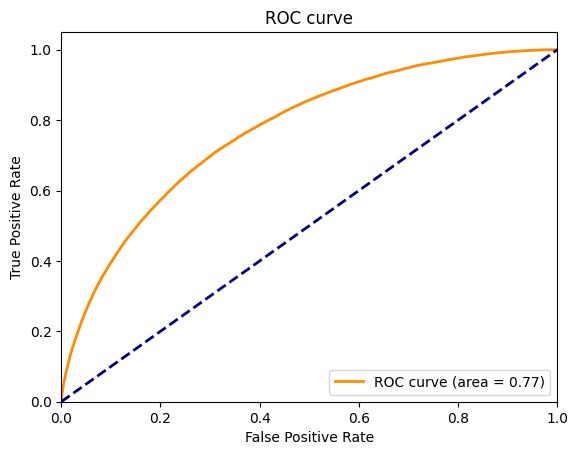

In [55]:
# Calcula as taxas de falso positivo (FPR), verdadeiro positivo (TPR) e os thresholds para a curva ROC
# - `metrics.roc_curve`: Recebe os valores reais ('mau') e as probabilidades preditas ('score') pelo modelo
# - FPR: Taxa de falsos positivos (proporção de não inadimplentes classificados incorretamente como inadimplentes)
# - TPR: Taxa de verdadeiros positivos (proporção de inadimplentes corretamente classificados como inadimplentes)
# - Thresholds: Pontos de corte usados para classificar como 1 ou 0 com base nas probabilidades
fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])

# Configura a criação de um gráfico
plt.figure()
lw = 2  # Define a largura da linha no gráfico

# Calcula novamente a curva ROC e a AUC (Área Sob a Curva)
# - `metrics.auc(fpr, tpr)`: Calcula a AUC com base nas taxas FPR e TPR
auc_ = metrics.auc(fpr, tpr)

# Plota a curva ROC
# - `plt.plot(fpr, tpr)`: Plota a TPR contra a FPR para diferentes valores de threshold
# - `color='darkorange'`: Define a cor da curva ROC
# - `label`: Inclui a AUC no rótulo da legenda
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)

# Plota uma linha diagonal representando a referência de classificação aleatória (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# Configura os limites do gráfico
plt.xlim([0.0, 1.0])  # Limites do eixo X (Taxa de Falsos Positivos)
plt.ylim([0.0, 1.05])  # Limites do eixo Y (Taxa de Verdadeiros Positivos)

# Configurações dos rótulos e título do gráfico
plt.xlabel('False Positive Rate')  # Rótulo do eixo X
plt.ylabel('True Positive Rate')  # Rótulo do eixo Y
plt.title('ROC curve')  # Título do gráfico

# Adiciona uma legenda ao gráfico
plt.legend(loc="lower right")  # Posiciona a legenda no canto inferior direito

# Exibe o gráfico
plt.show()


Text(0, 0.5, 'Função Distribuição Acumulada')

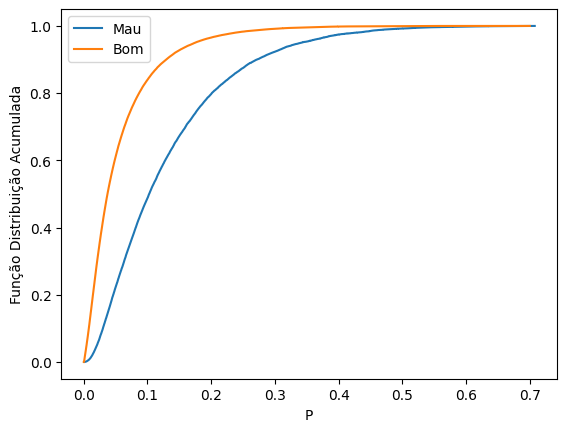

In [56]:
# Cria uma figura para o gráfico
fig = plt.figure()

# Adiciona um único subplot na figura
# - `add_subplot(1, 1, 1)`: Cria um grid 1x1 e adiciona o primeiro (e único) gráfico ao espaço
ax = fig.add_subplot(1, 1, 1)

# Seleciona os escores da população de clientes inadimplentes ('mau' == 1)
score_pop1 = df_train.loc[df_train['mau'] == 1, 'score']

# Plota a Função de Distribuição Acumulada (CDF) dos escores para clientes inadimplentes
# - `np.sort(score_pop1)`: Ordena os escores da população inadimplente em ordem crescente
# - `np.linspace(0, 1, len(score_pop1), endpoint=False)`: Gera valores uniformemente espaçados entre 0 e 1
#   para representar a proporção cumulativa dos escores
ax.plot(
    np.sort(score_pop1),                          # Valores ordenados de escores
    np.linspace(0, 1, len(score_pop1), endpoint=False),  # Proporção cumulativa
    label='Mau'                                   # Rótulo da curva
)

# Seleciona os escores da população de clientes adimplentes ('mau' != 1)
score_pop2 = df_train.loc[df_train['mau'] != 1, 'score']

# Plota a Função de Distribuição Acumulada (CDF) dos escores para clientes adimplentes
ax.plot(
    np.sort(score_pop2),                          # Valores ordenados de escores
    np.linspace(0, 1, len(score_pop2), endpoint=False),  # Proporção cumulativa
    label='Bom'                                   # Rótulo da curva
)

# Adiciona uma legenda para diferenciar as curvas (Mau e Bom)
ax.legend()

# Configura os rótulos dos eixos
ax.set_xlabel('P')  # Rótulo do eixo X (escores preditos)
ax.set_ylabel('Função Distribuição Acumulada')  # Rótulo do eixo Y (proporção cumulativa)


##Insight 1

- Acurácia (71.9%): O modelo classifica corretamente a maioria dos casos, mas a acurácia isoladamente pode não ser suficiente para avaliar a performance, especialmente se o conjunto de dados for desbalanceado.

- AUC (77%): Indica que o modelo tem um bom poder discriminatório. Valores acima de 70% são geralmente considerados aceitáveis.

- GINI (54%): Um GINI acima de 50% sugere que o modelo está separando bem as classes, mas ainda pode ser otimizado.

- KS (39.9%): Um KS acima de 40% é considerado um bom sinal de discriminação entre classes, porém, valores próximos de 50% seriam ideais.

In [57]:
# Preenche os valores ausentes (NaN) na coluna 'tempo_emprego' do DataFrame 'df_test'
# - `df_test['tempo_emprego'].fillna(...)`: Localiza os valores ausentes na coluna 'tempo_emprego' do conjunto de teste
# - `value=df_test['tempo_emprego'].mean()`: Substitui os valores ausentes pela média da coluna 'tempo_emprego'
# - `inplace=True`: Aplica a modificação diretamente no DataFrame, sem criar uma nova cópia
df_test['tempo_emprego'].fillna(value=df_test['tempo_emprego'].mean(), inplace=True)


In [58]:
# Agrupa categorias da coluna 'educacao' no DataFrame 'df_test' em novas categorias mais amplas
# - `df_test.educacao.replace(...)`: Substitui valores específicos na coluna 'educacao' com base em um dicionário de mapeamento
# - O dicionário de mapeamento:
#   - {'Fundamental': 'Fund/Médio/Sup Incomp', 'Médio': 'Fund/Médio/Sup Incomp', 'Superior incompleto': 'Fund/Médio/Sup Incomp'}:
#       Agrupa categorias de níveis educacionais mais baixos em 'Fund/Médio/Sup Incomp'.
#   - {'Superior completo': 'Sup Comp/Pós', 'Pós graduação': 'Sup Comp/Pós'}:
#       Agrupa categorias de níveis educacionais mais altos em 'Sup Comp/Pós'.
# - `inplace=True`: Aplica a modificação diretamente no DataFrame sem criar uma cópia
df_test.educacao.replace({'Fundamental': 'Fund/Médio/Sup Incomp',
                          'Médio': 'Fund/Médio/Sup Incomp',
                          'Superior incompleto': 'Fund/Médio/Sup Incomp',
                          'Superior completo': 'Sup Comp/Pós',
                          'Pós graduação': 'Sup Comp/Pós'},
                         inplace=True)


In [59]:
# Adiciona uma coluna 'score' ao DataFrame 'df_test'
# - 'rl.predict(df_test)': Utiliza o modelo ajustado ('rl') para prever as probabilidades de inadimplência no conjunto de teste
# - O resultado é armazenado na nova coluna 'score', que contém as probabilidades previstas para cada cliente
df_test['score'] = rl.predict(df_test)

# Calcula a acurácia do modelo no conjunto de teste
# - `metrics.accuracy_score`: Compara os valores reais ('mau') com os valores preditos (convertidos para classes binárias com threshold de 0.068)
# - `df_test.score > .068`: Classifica como 1 (inadimplente) se a probabilidade for maior que 6.8%, ou 0 caso contrário
acc = metrics.accuracy_score(df_test.mau, df_test.score > .068)

# Calcula a AUC (Área Sob a Curva ROC) no conjunto de teste
# - `metrics.roc_curve`: Calcula as taxas de falso positivo (FPR), verdadeiro positivo (TPR) e os thresholds para a curva ROC
# - `metrics.auc`: Calcula a AUC com base nas taxas FPR e TPR
fpr, tpr, thresholds = metrics.roc_curve(df_test.mau, df_test.score)
auc = metrics.auc(fpr, tpr)

# Calcula o índice Gini
# - Gini é derivado da AUC e avalia o poder discriminatório do modelo
# - Fórmula: Gini = 2 * AUC - 1
gini = 2 * auc - 1

# Calcula o KS (Kolmogorov-Smirnov) no conjunto de teste
# - `ks_2samp`: Realiza o teste KS para medir a maior diferença cumulativa entre as distribuições de escores
#   dos grupos de inadimplentes ('mau == 1') e adimplentes ('mau != 1')
ks = ks_2samp(
    df_test.loc[df_test.mau == 1, 'score'],   # Escores para inadimplentes
    df_test.loc[df_test.mau != 1, 'score']   # Escores para adimplentes
).statistic

# Exibe as métricas de desempenho do modelo no conjunto de teste
# - Acurácia: Percentual de classificações corretas
# - AUC: Mede a capacidade do modelo de distinguir entre inadimplentes e adimplentes
# - GINI: Métrica derivada da AUC para avaliar o poder discriminatório
# - KS: Diferença máxima entre as distribuições acumuladas de escores para inadimplentes e adimplentes
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 39.3% 
AUC: 73.9% 
GINI: 47.8%
KS: 34.7%


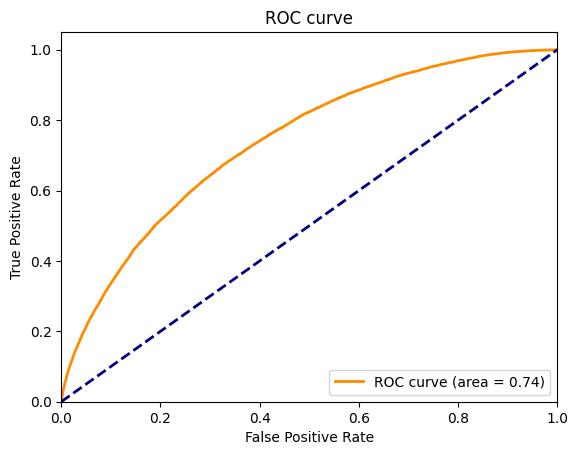

In [60]:
# Calcula as taxas de falso positivo (FPR), verdadeiro positivo (TPR) e os thresholds para a curva ROC
# - `metrics.roc_curve`: Gera a curva ROC usando os valores reais ('mau') e as probabilidades preditas ('score')
# - FPR (False Positive Rate): Proporção de não inadimplentes classificados incorretamente como inadimplentes
# - TPR (True Positive Rate): Proporção de inadimplentes classificados corretamente como inadimplentes
# - Thresholds: Pontos de corte para transformar probabilidades em classificações binárias
fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])

# Cria uma nova figura para o gráfico da curva ROC
plt.figure()

# Define a largura das linhas no gráfico
lw = 2

# Calcula novamente a curva ROC e a AUC (Área Sob a Curva ROC)
# - `metrics.auc(fpr, tpr)`: Calcula a área sob a curva ROC, que mede a capacidade do modelo de separar classes
auc_ = metrics.auc(fpr, tpr)

# Plota a curva ROC
# - `plt.plot(fpr, tpr)`: Plota TPR (eixo Y) contra FPR (eixo X) para diferentes thresholds
# - `color='darkorange'`: Define a cor da curva ROC
# - `label='ROC curve (area = %0.2f)' % auc_`: Adiciona a AUC como rótulo na legenda
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)

# Plota a linha de referência diagonal, que representa uma classificação aleatória (AUC = 0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# Define os limites do gráfico
plt.xlim([0.0, 1.0])  # Limites do eixo X (Taxa de Falsos Positivos)
plt.ylim([0.0, 1.05])  # Limites do eixo Y (Taxa de Verdadeiros Positivos)

# Define os rótulos dos eixos
plt.xlabel('False Positive Rate')  # Rótulo do eixo X
plt.ylabel('True Positive Rate')  # Rótulo do eixo Y

# Define o título do gráfico
plt.title('ROC curve')

# Adiciona uma legenda para identificar a curva ROC e a linha de referência
plt.legend(loc="lower right")  # Posiciona a legenda no canto inferior direito

# Exibe o gráfico da curva ROC
plt.show()


Text(0, 0.5, 'Função Distribuição Acumulada')

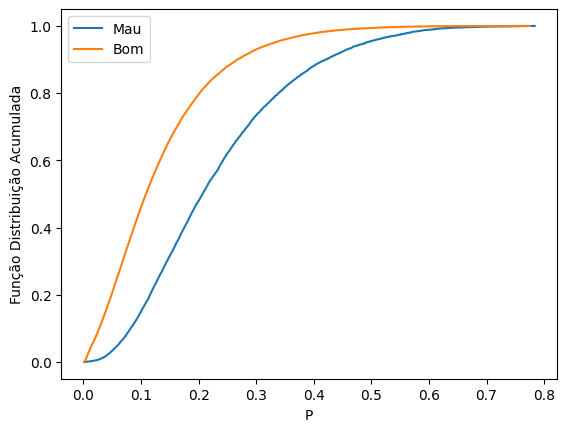

In [61]:
# Cria uma nova figura para o gráfico
fig = plt.figure()

# Adiciona um único subplot à figura
# - `add_subplot(1, 1, 1)`: Define uma grade 1x1 de subplots e adiciona o único gráfico ao espaço
ax = fig.add_subplot(1, 1, 1)

# Seleciona os escores da população de clientes inadimplentes ('mau' == 1) no conjunto de teste
# - `df_test.loc[df_test['mau'] == 1, 'score']`: Filtra as linhas do DataFrame onde 'mau' é 1 e obtém os valores da coluna 'score'
score_pop1 = df_test.loc[df_test['mau'] == 1, 'score']

# Plota a Função de Distribuição Acumulada (CDF) dos escores para clientes inadimplentes
# - `np.sort(score_pop1)`: Ordena os escores da população inadimplente em ordem crescente
# - `np.linspace(0, 1, len(score_pop1), endpoint=False)`: Gera valores entre 0 e 1 que representam a proporção cumulativa dos escores
# - `label='Mau'`: Define o rótulo da curva para indicar que é referente aos inadimplentes
ax.plot(
    np.sort(score_pop1),                          # Escores ordenados
    np.linspace(0, 1, len(score_pop1), endpoint=False),  # Proporção cumulativa
    label='Mau'                                   # Rótulo para a legenda
)

# Seleciona os escores da população de clientes adimplentes ('mau' != 1) no conjunto de teste
score_pop2 = df_test.loc[df_test['mau'] != 1, 'score']

# Plota a Função de Distribuição Acumulada (CDF) dos escores para clientes adimplentes
# - `np.sort(score_pop2)`: Ordena os escores da população adimplente em ordem crescente
# - `np.linspace(0, 1, len(score_pop2), endpoint=False)`: Gera a proporção cumulativa dos escores
# - `label='Bom'`: Define o rótulo da curva para indicar que é referente aos adimplentes
ax.plot(
    np.sort(score_pop2),                          # Escores ordenados
    np.linspace(0, 1, len(score_pop2), endpoint=False),  # Proporção cumulativa
    label='Bom'                                   # Rótulo para a legenda
)

# Adiciona uma legenda ao gráfico para diferenciar as curvas (Mau e Bom)
ax.legend()

# Configura os rótulos dos eixos
ax.set_xlabel('P')  # Rótulo do eixo X, representando os escores preditos ('score')
ax.set_ylabel('Função Distribuição Acumulada')  # Rótulo do eixo Y, representando a proporção cumulativa


##Insight 2


- Acurácia: 39.3%

O modelo está classificando corretamente apenas 39.3% dos casos no conjunto de teste.
Uma baixa acurácia pode indicar que o modelo está enfrentando dificuldades para fazer previsões corretas ou que a base está desbalanceada.

- AUC: 73.9%

O modelo tem um poder de discriminação razoável, pois a AUC acima de 70% sugere que ele consegue diferenciar inadimplentes e adimplentes com um bom nível de precisão.
Quanto mais próximo de 100%, melhor a separação das classes.

- GINI: 47.8%

O GINI é calculado como 2 * AUC - 1, resultando em 47.8%.
Valores acima de 40% indicam um modelo útil, mas um GINI acima de 50% seria preferível.

- KS: 47.8%

O KS mede a maior diferença entre as distribuições de escores dos grupos (inadimplentes e adimplentes).
Valores acima de 40% são considerados bons, e um KS acima de 50% indicaria um modelo ainda mais forte.